# Telecom Churn Case Study¶
- In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
- For many incumbent operators, retaining high profitable customers is the number one business goal.
- To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.
In this project, we will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

In [1]:
#Import all the required libraries:
import sys
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import confusion_matrix

# Importing classification report and confusion matrix from sklearn metrics:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

warnings.filterwarnings('ignore')
%matplotlib inline

## Importing Telecom Data

In [2]:
telecom_df = pd.read_csv('/content/telecom_churn_data.csv')

In [3]:
telecom_df.info()
telecom_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6611 entries, 0 to 6610
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(212), int64(2), object(12)
memory usage: 11.4+ MB


mobile_number  circle_id  loc_og_t2o_mou  ...  jul_vbc_3g  jun_vbc_3g sep_vbc_3g
0     7000842753        109             0.0  ...         0.0      101.20       3.58
1     7001865778        109             0.0  ...         0.0        0.00       0.00
2     7001625959        109             0.0  ...         0.0        4.17       0.00
3     7001204172        109             0.0  ...         0.0        0.00       0.00
4     7000142493        109             0.0  ...         0.0        0.00       0.00

[5 rows x 226 columns]

In [4]:
round(100*(telecom_df.isnull().sum()/len(telecom_df.index)), 2)

mobile_number     0.00
circle_id         0.00
loc_og_t2o_mou    1.00
std_og_t2o_mou    1.00
loc_ic_t2o_mou    1.00
                  ... 
aon               0.02
aug_vbc_3g        0.02
jul_vbc_3g        0.02
jun_vbc_3g        0.02
sep_vbc_3g        0.02
Length: 226, dtype: float64

## Data Preparation
- Scoping our sample to the High valued customer (top 30%) who demonstrated high spending in the initial two months.
- Churn Indicator created based on the provided business logics

In [5]:
# create Churn data

telecom_df1 = telecom_df
telecom_df1['total_rech_amt_good_phase'] = (telecom_df1['total_rech_amt_6'] + telecom_df1['total_rech_amt_7'])/2
telecom_df1 = telecom_df1[telecom_df1['total_rech_amt_good_phase'] > telecom_df1['total_rech_amt_good_phase'].quantile(0.70)]

telecom_df1['total_usage_col'] = telecom_df1['total_og_mou_9'] + telecom_df1['total_ic_mou_9'] + telecom_df1['vol_2g_mb_9'] + telecom_df1['vol_3g_mb_9']

telecom_df1['churn'] = np.where(telecom_df1['total_usage_col']== 0, 1, 0)
telecom_df1['churn'].value_counts()

0    1803
1     175
Name: churn, dtype: int64

In [6]:
telecom_df1 = telecom_df1.drop(['total_rech_amt_good_phase','total_usage_col'],1)

- As per the analysis scope dropping all the variables of the 9th month after the churn indicator creation

In [7]:
nine_col = [col for col in telecom_df1.columns if '_9' in col]
print(telecom_df1.shape)
telecom_df1 = telecom_df1.drop(nine_col, axis = 1)
print(telecom_df1.shape)
telecom_df1 = telecom_df1.drop('sep_vbc_3g', axis=1)

(1978, 227)
(1978, 173)


### Churn rate:

In [8]:
y = telecom_df1['churn']
churn = (sum(y)/len(y.index))*100
print(churn)
print(telecom_df1.shape)

8.84732052578362
(1978, 172)


#### Thus the churn rate is 8.63%.

In [9]:
telecom_df1.describe()

mobile_number  circle_id  ...   jun_vbc_3g        churn
count   1.978000e+03     1978.0  ...  1978.000000  1978.000000
mean    7.001211e+09      109.0  ...   112.967508     0.088473
std     6.955174e+05        0.0  ...   357.918585     0.284054
min     7.000000e+09      109.0  ...     0.000000     0.000000
25%     7.000604e+09      109.0  ...     0.000000     0.000000
50%     7.001224e+09      109.0  ...     0.000000     0.000000
75%     7.001826e+09      109.0  ...     0.000000     0.000000
max     7.002409e+09      109.0  ...  4688.590000     1.000000

[8 rows x 163 columns]

In [10]:
round(100*(telecom_df1.isnull().sum()/len(telecom_df1.index)), 2)

mobile_number     0.00
circle_id         0.00
loc_og_t2o_mou    0.25
std_og_t2o_mou    0.25
loc_ic_t2o_mou    0.25
                  ... 
aon               0.00
aug_vbc_3g        0.00
jul_vbc_3g        0.00
jun_vbc_3g        0.00
churn             0.00
Length: 172, dtype: float64

### Dropping colums with only one unique value (showing zero variance)

In [11]:
#delete coloum as all value are zero or constant
telecom_df2 = telecom_df1.drop(['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6',
                     'std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7',
                   'std_ic_t2o_mou_8','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'], 1)

In [12]:
#Droping colume
fields_to_be_imputed_with_2 = ['fb_user','night_pck_user','arpu_2g','arpu_3g','av_rech_amt_data','count_rech_3g',
'count_rech_2g','max_rech_data','total_rech_data','date_of_last_rech_data']

for field in fields_to_be_imputed_with_2:
    for month in ['6', '7', '8']:
        field_to_be_imputed_with_2 = field + '_' + month
        telecom_df2 = telecom_df2.drop([field_to_be_imputed_with_2], 1)
        
print(telecom_df2.shape)

(1978, 129)


In [13]:
fields_to_be_imputed_with_2 = ['date_of_last_rech']

for field in fields_to_be_imputed_with_2:
    for month in ['6', '7', '8']:
        field_to_be_imputed_with_2 = field + '_' + month
        telecom_df2[field_to_be_imputed_with_2].fillna(telecom_df2[field_to_be_imputed_with_2].mode()[0], inplace=True)

In [14]:
telecom_df2['date_of_last_rech_6'] = pd.to_datetime(telecom_df2.date_of_last_rech_6).dt.day
telecom_df2['date_of_last_rech_7'] = pd.to_datetime(telecom_df2.date_of_last_rech_7).dt.day
telecom_df2['date_of_last_rech_8'] = pd.to_datetime(telecom_df2.date_of_last_rech_8).dt.day

#### Imputing missing observations with Median column value

In [15]:
missing_cols = telecom_df2.columns[telecom_df2.isnull().sum()>0]
for col in missing_cols:
    telecom_df2[col].fillna((telecom_df2[col].median()), inplace=True)

In [16]:
round(100*(telecom_df2.isnull().sum()/len(telecom_df2.index)), 2)

mobile_number    0.0
arpu_6           0.0
arpu_7           0.0
arpu_8           0.0
onnet_mou_6      0.0
                ... 
aon              0.0
aug_vbc_3g       0.0
jul_vbc_3g       0.0
jun_vbc_3g       0.0
churn            0.0
Length: 129, dtype: float64

In [17]:
telecom_df3 = telecom_df2
telecom_df3.shape

(1978, 129)

## Outlier Treatment

In [18]:
telecom_df3.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])
#As we can see we have outlier.

mobile_number       arpu_6  ...   jun_vbc_3g        churn
count   1.978000e+03  1978.000000  ...  1978.000000  1978.000000
mean    7.001211e+09   592.095266  ...   112.967508     0.088473
std     6.955174e+05   385.440746  ...   357.918585     0.284054
min     7.000000e+09 -2041.228000  ...     0.000000     0.000000
1%      7.000028e+09     8.557520  ...     0.000000     0.000000
10%     7.000260e+09   275.340400  ...     0.000000     0.000000
25%     7.000604e+09   375.061000  ...     0.000000     0.000000
50%     7.001224e+09   509.852500  ...     0.000000     0.000000
75%     7.001826e+09   713.584750  ...     0.000000     0.000000
90%     7.002172e+09   979.105300  ...   377.249000     0.000000
95%     7.002280e+09  1218.900250  ...   723.308000     1.000000
99%     7.002383e+09  2055.424220  ...  1815.119800     1.000000
max     7.002409e+09  4176.128000  ...  4688.590000     1.000000

[13 rows x 129 columns]

In [19]:
cont_cols = [col for col in telecom_df3.columns if col not in ['churn','mobile_number']]

for col in cont_cols:
    percentiles = telecom_df3[col].quantile([0.01,0.99]).values
    telecom_df3[col][telecom_df3[col] <= percentiles[0]] = percentiles[0]
    telecom_df3[col][telecom_df3[col] >= percentiles[1]] = percentiles[1]

In [20]:
telecom_df3.shape

(1978, 129)

In [21]:
telecom_df3.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

mobile_number       arpu_6  ...   jun_vbc_3g        churn
count   1.978000e+03  1978.000000  ...  1978.000000  1978.000000
mean    7.001211e+09   586.198060  ...   105.645908     0.088473
std     6.955174e+05   338.061272  ...   302.084072     0.284054
min     7.000000e+09     8.557520  ...     0.000000     0.000000
1%      7.000028e+09     8.872050  ...     0.000000     0.000000
10%     7.000260e+09   275.340400  ...     0.000000     0.000000
25%     7.000604e+09   375.061000  ...     0.000000     0.000000
50%     7.001224e+09   509.852500  ...     0.000000     0.000000
75%     7.001826e+09   713.584750  ...     0.000000     0.000000
90%     7.002172e+09   979.105300  ...   377.249000     0.000000
95%     7.002280e+09  1218.900250  ...   723.308000     1.000000
99%     7.002383e+09  2051.773481  ...  1797.363754     1.000000
max     7.002409e+09  2055.424220  ...  1815.119800     1.000000

[13 rows x 129 columns]

#### Creating derived colums
- Average values of 3 months for each attributes were created to check if that value could address all the months.
- Median value of Internet usage (2G + 3G) across months was created to capture the churn rate as it was observed majority of the churn happens when the internet usage pattern shows a decline
- The AON variable was used to create tenure buckets. It was observed larger the tenure, lesser was the churn - as customers who are newly acquired to the network churned more as compared to the old customers.

In [22]:
telecom_df3['int_usage_median'] = telecom_df3[['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8']].median(axis=1)
telecom_df3['int_usage_median'] = telecom_df3.int_usage_median.map(lambda x: 1 if x == 0 else 0)
telecom_df3 = telecom_df3.drop(['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'], 1)


telecom_df3['tenure_buck'] = np.round(telecom_df3['aon']/365,1)
bins = [0, 1, 2, 3, 4, 10]
telecom_df3['tenure_buck'] = pd.cut(telecom_df3['tenure_buck'], bins)
telecom_df3['tenure_buck'].value_counts()

(4, 10]    638
(1, 2]     488
(0, 1]     347
(2, 3]     307
(3, 4]     198
Name: tenure_buck, dtype: int64

### Correlation Analysis

In [23]:
# Create correlation matrix
corr_matrix = telecom_df3.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
to_drop

telecom_df3 = telecom_df3.drop(to_drop, 1)

In [24]:
telecom_df3.tenure_buck.dtype

CategoricalDtype(categories=[(0, 1], (1, 2], (2, 3], (3, 4], (4, 10]],
              ordered=True)

In [25]:
#create dummy for tenure_buck 
telecom_df3 = pd.get_dummies(telecom_df3, drop_first=True)

In [26]:
telecom_df3.rename(columns={"tenure_buck_(1, 2]": "tenure_buck_1_to_2","tenure_buck_(2, 3]":"tenure_buck_2_to_3",
                   "tenure_buck_(3, 4]":"tenure_buck_3_to_4",
                   "tenure_buck_(4, 10]":"tenure_buck_4_to_10"}, inplace=True)

In [27]:
telecom_df3.shape

(1978, 71)

In [28]:
# After outlier treatment droping column which don't have much variance or zero variance
telecom_df4 = telecom_df3.drop(['og_others_7','og_others_8','spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','aon'], 1)

In [29]:
telecom_df4.shape

(1978, 65)

## Exploratory data analysis

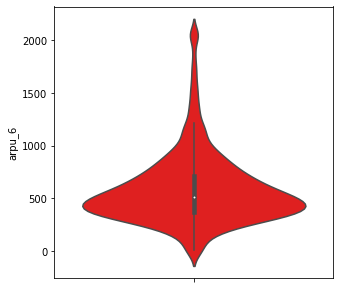

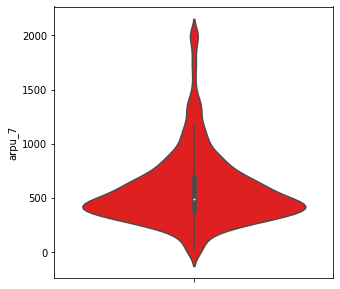

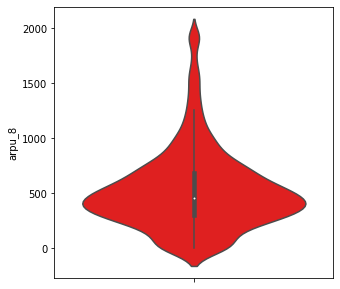

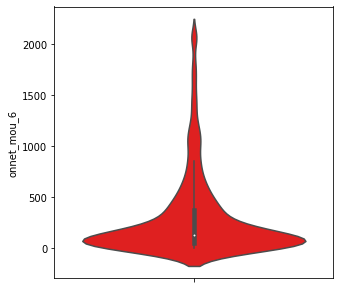

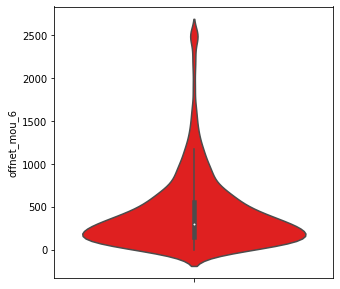

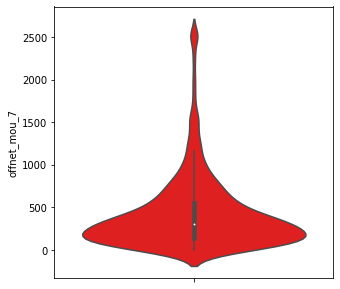

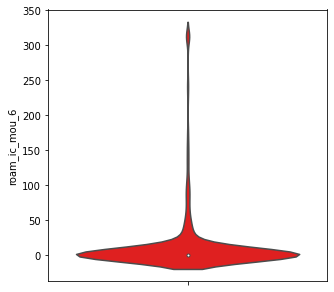

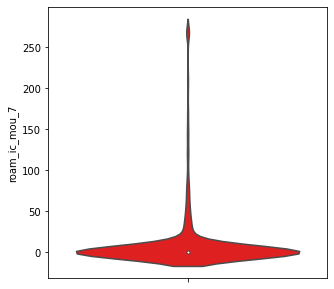

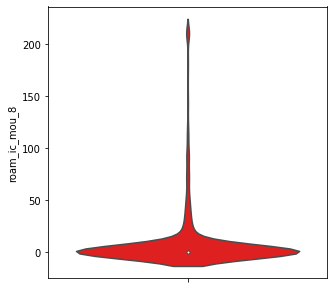

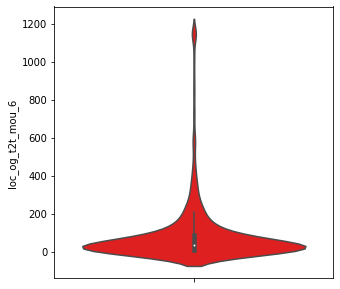

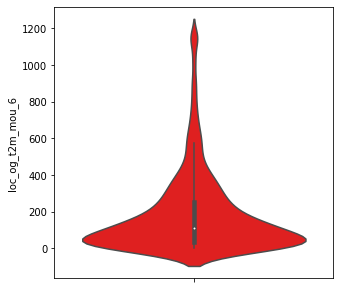

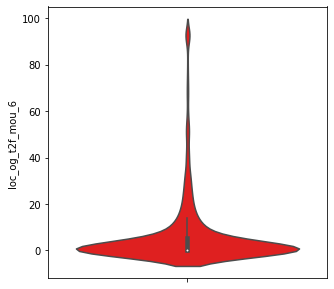

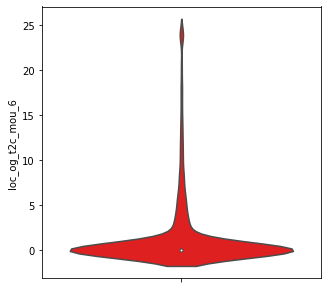

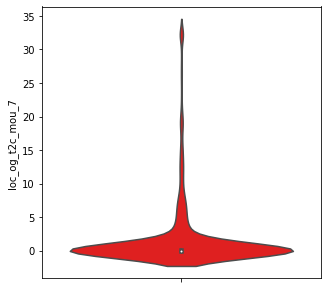

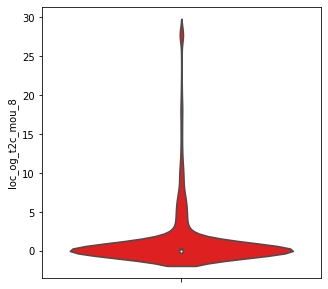

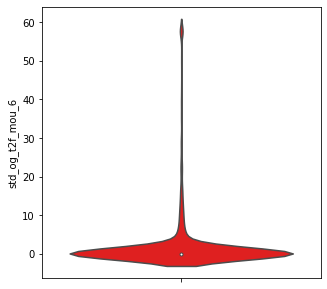

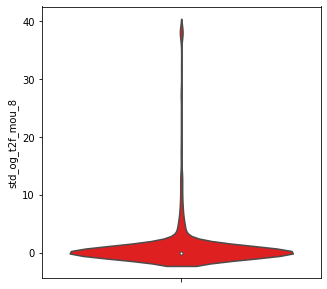

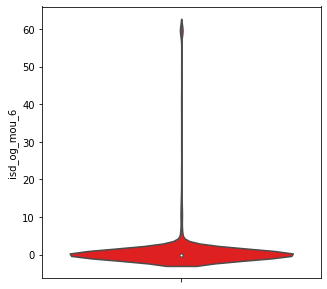

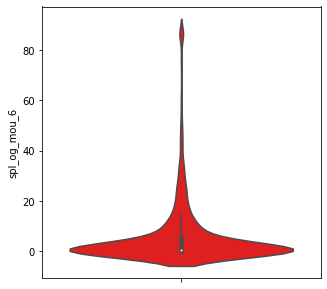

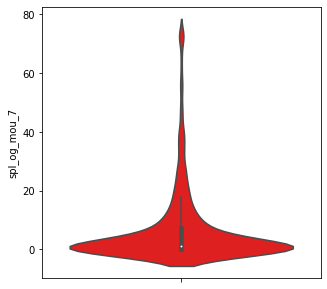

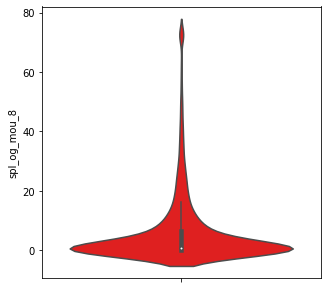

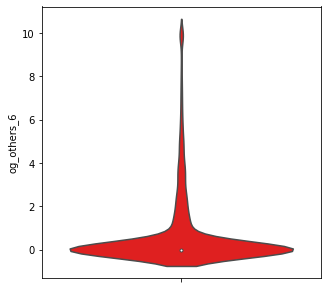

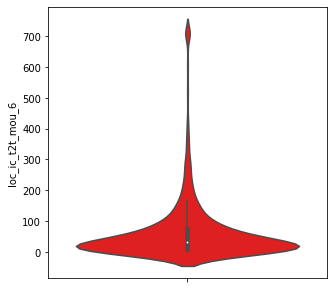

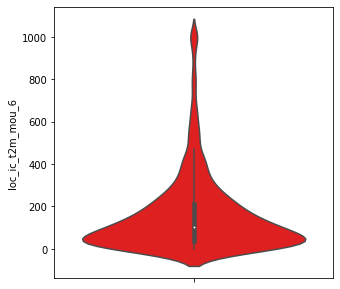

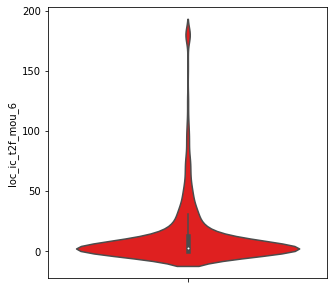

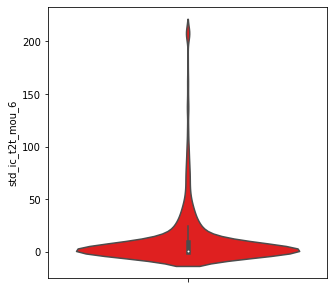

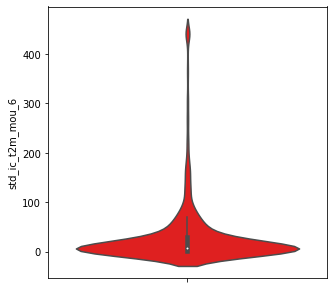

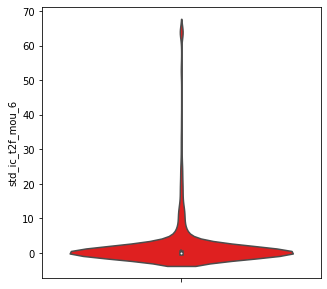

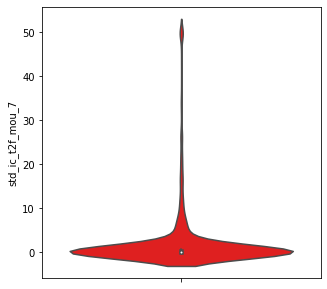

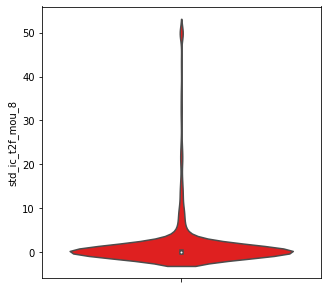

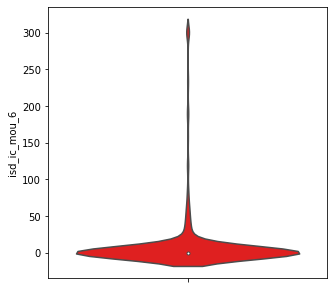

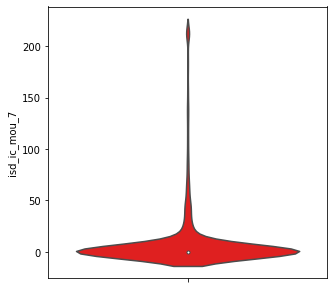

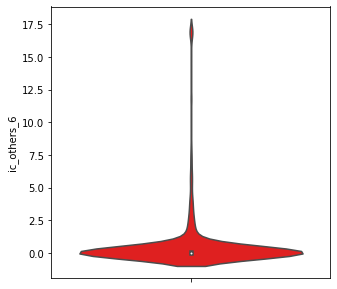

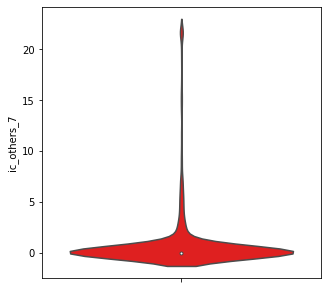

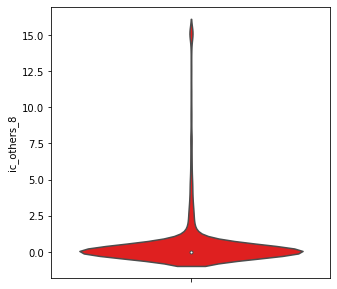

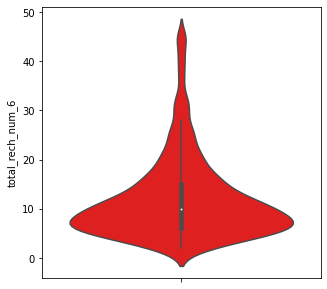

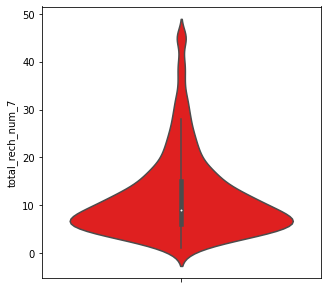

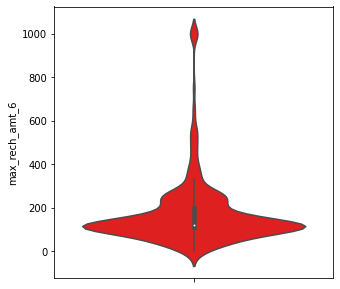

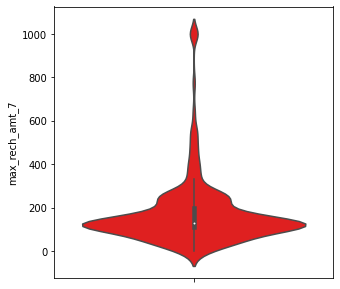

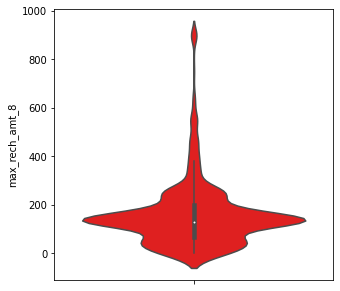

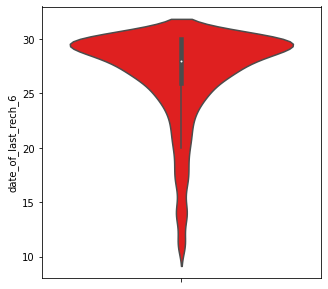

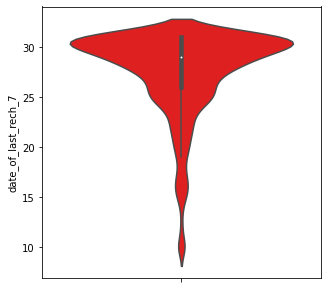

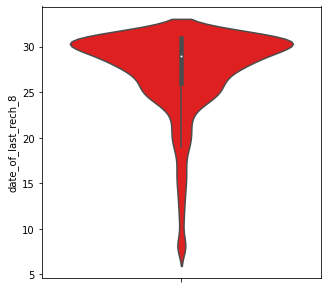

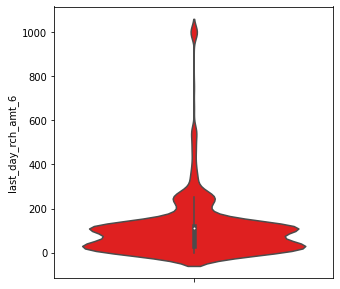

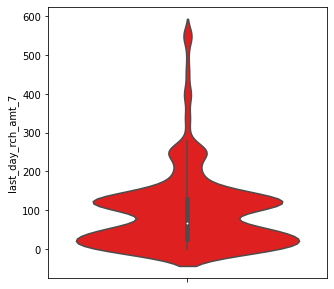

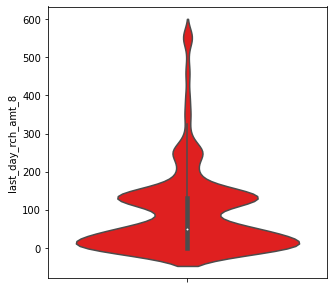

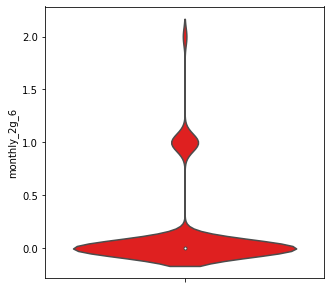

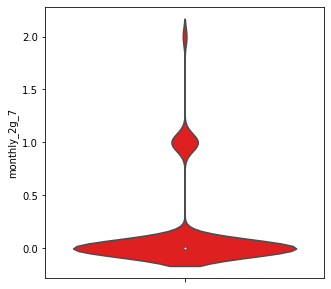

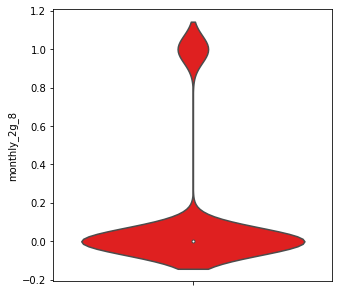

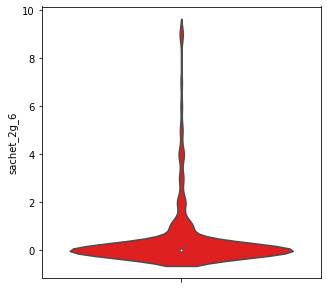

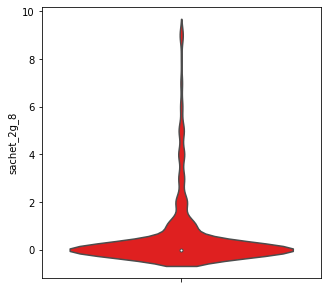

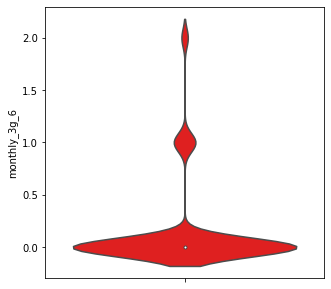

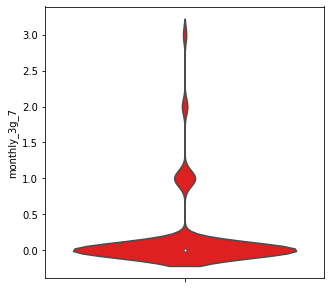

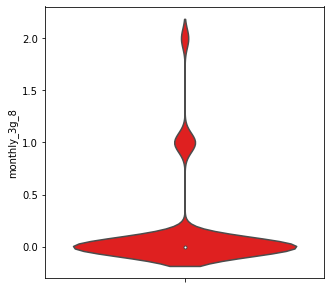

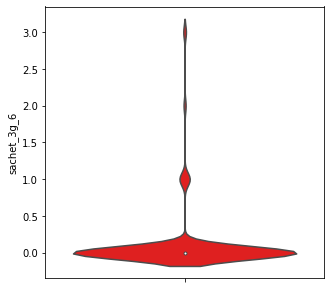

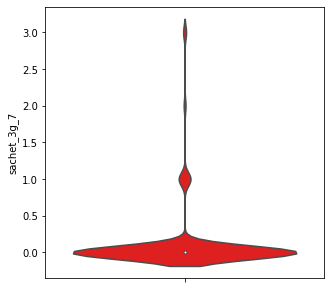

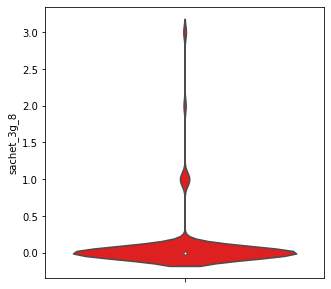

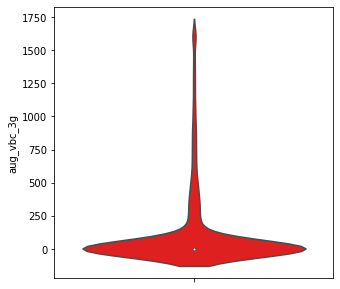

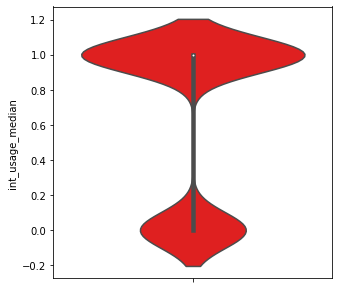

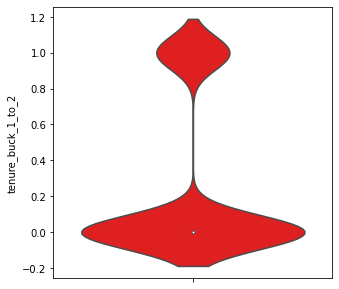

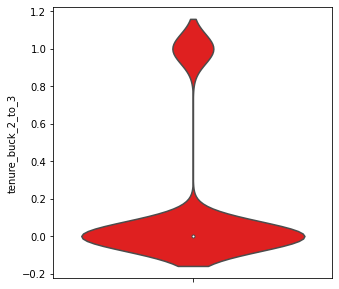

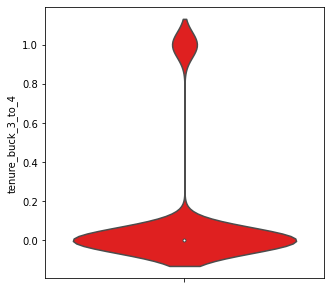

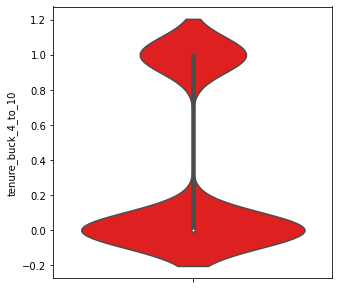

In [30]:
cont_cols = [col for col in telecom_df4.columns if col not in ['churn','mobile_number']]
for col in cont_cols:
    plt.figure(figsize=(5, 5))
    sns.violinplot(y=col, data=telecom_df4, fill='#A4A4A4', color="red")

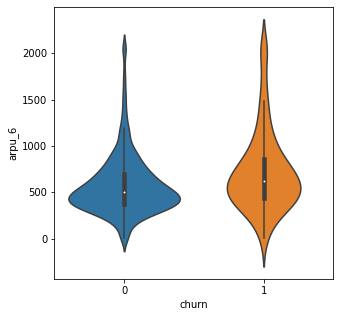

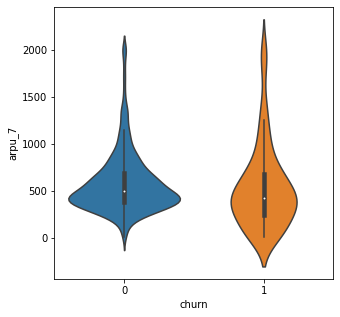

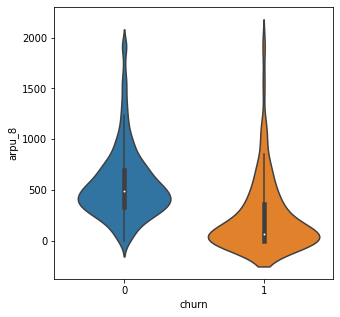

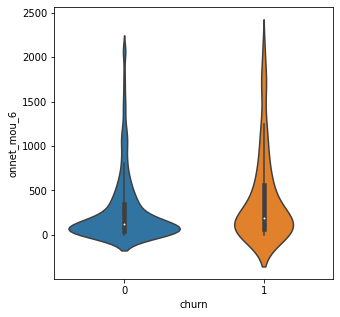

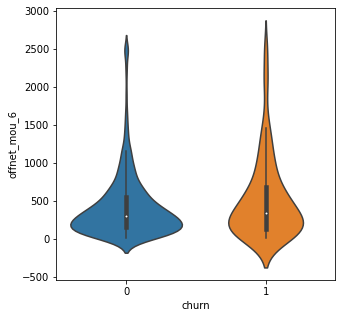

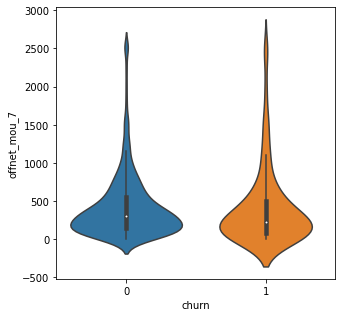

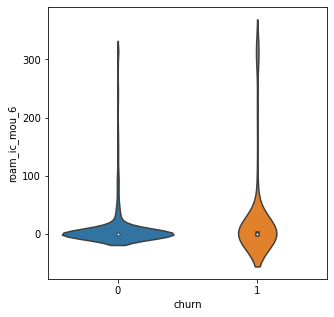

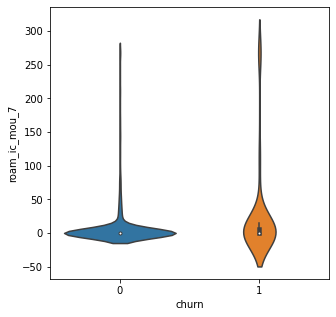

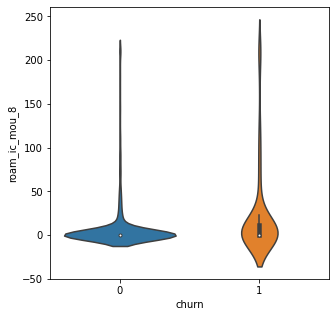

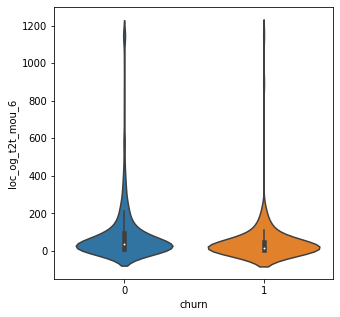

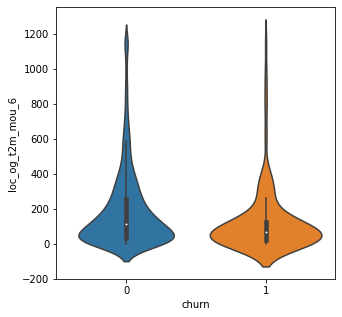

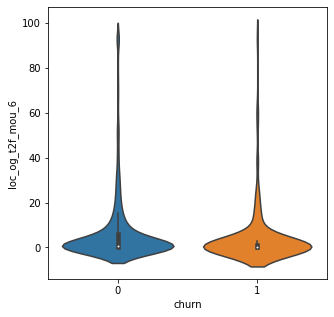

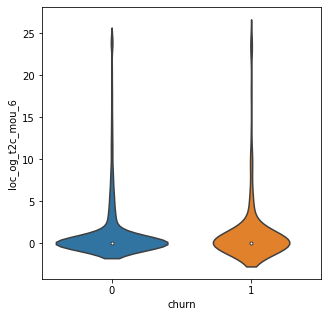

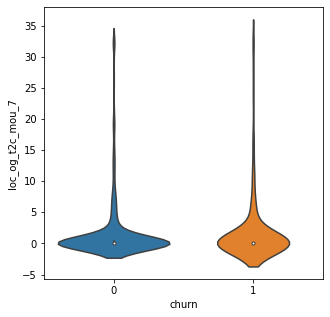

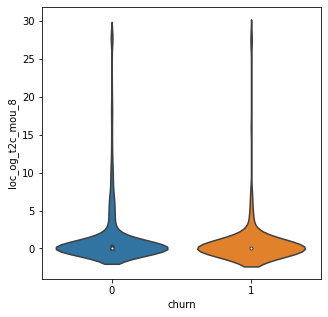

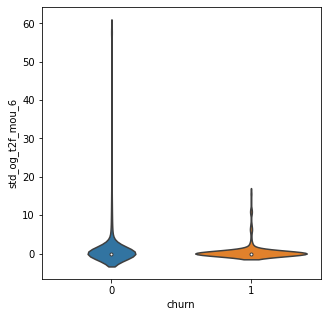

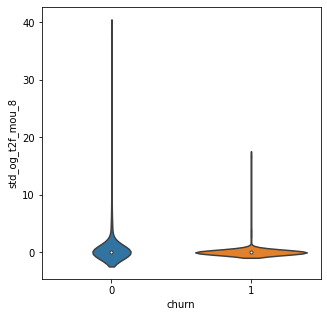

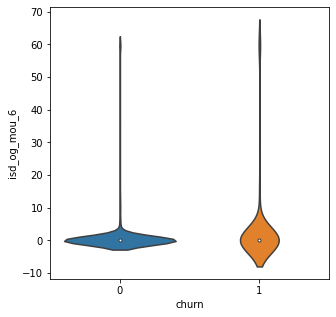

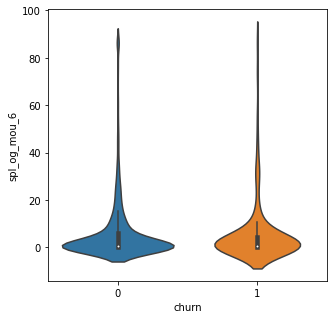

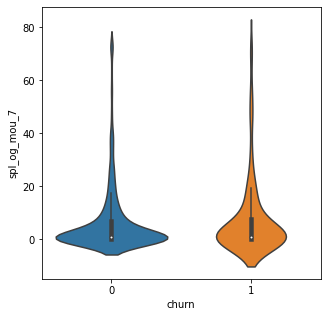

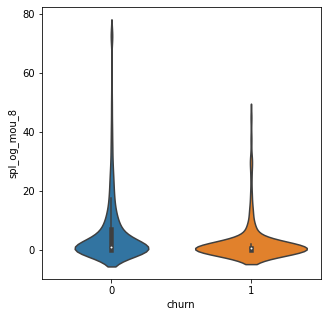

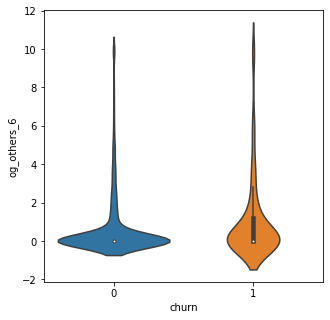

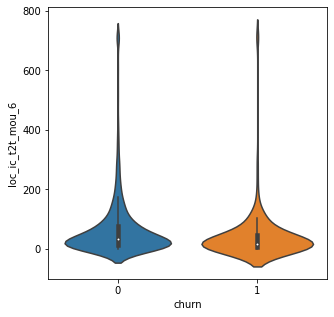

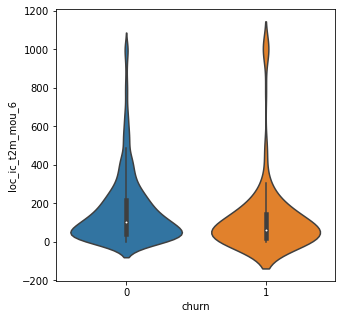

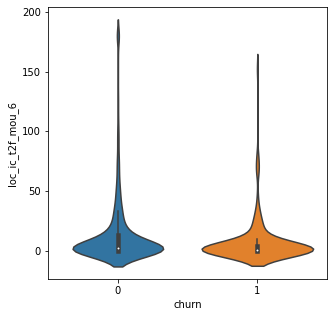

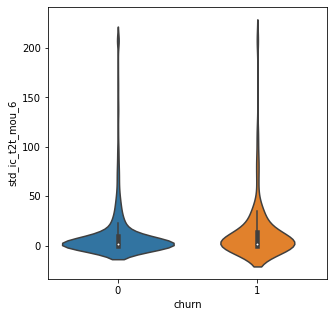

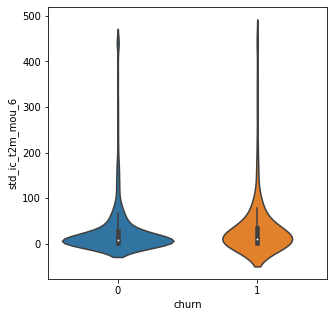

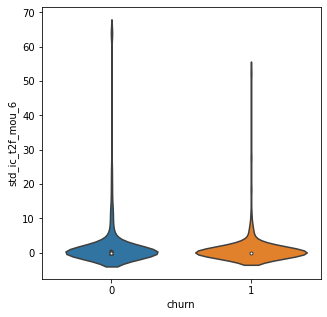

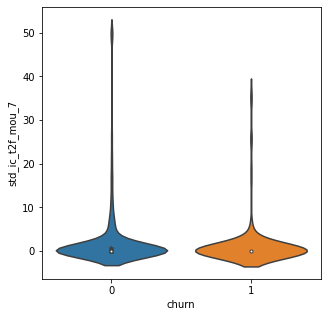

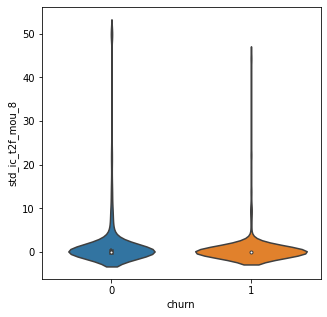

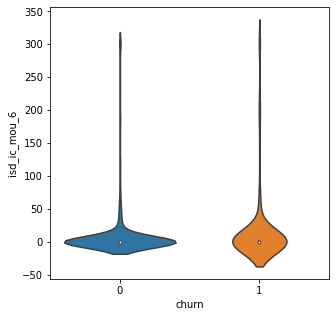

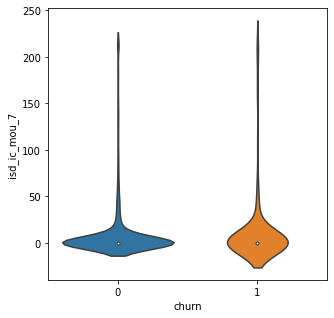

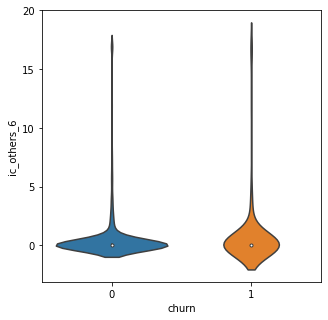

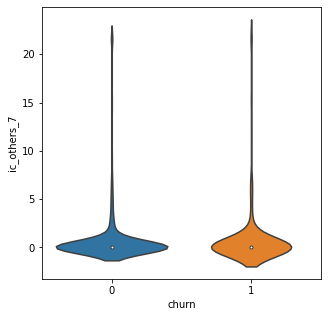

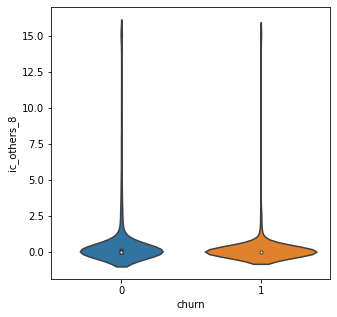

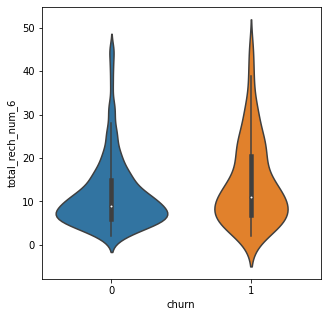

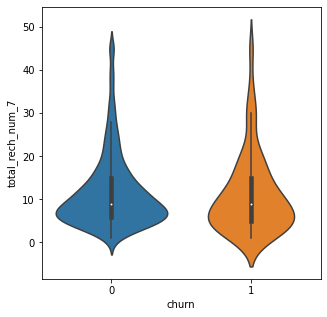

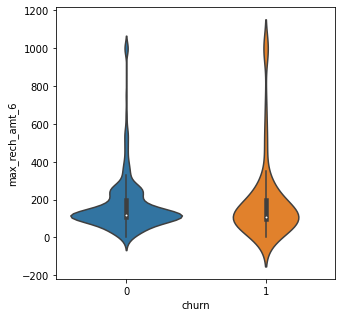

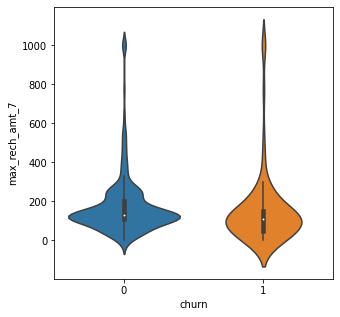

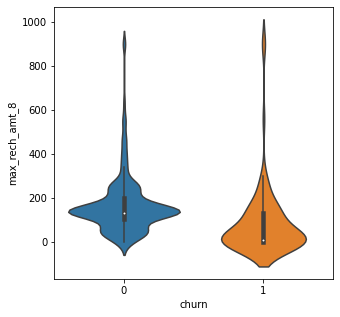

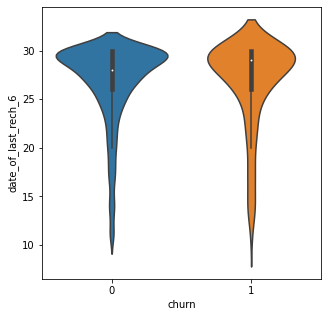

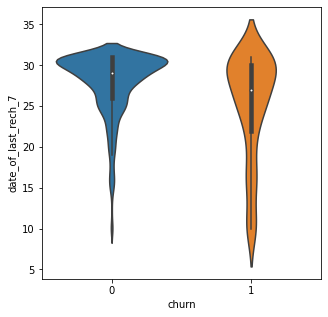

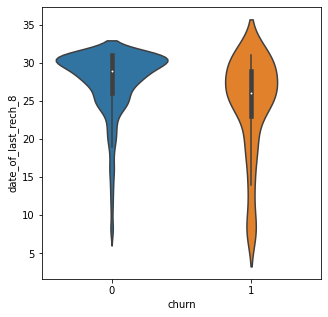

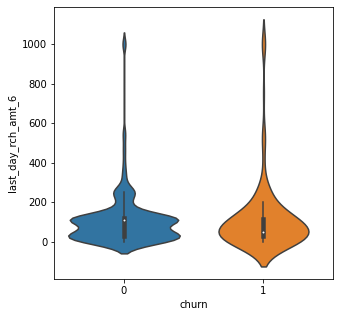

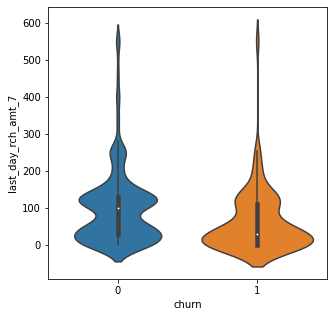

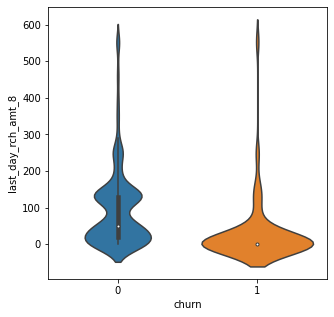

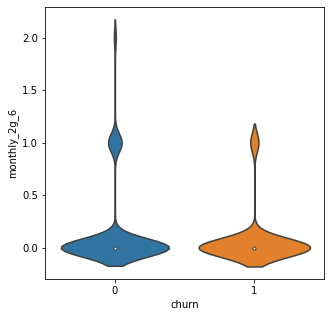

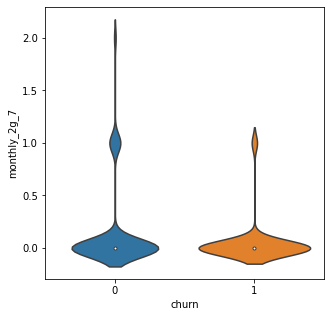

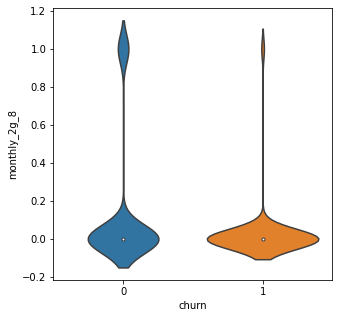

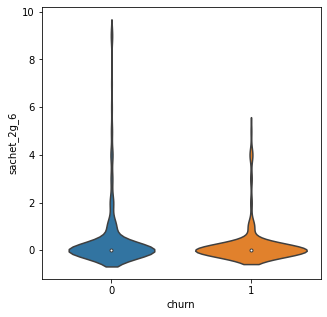

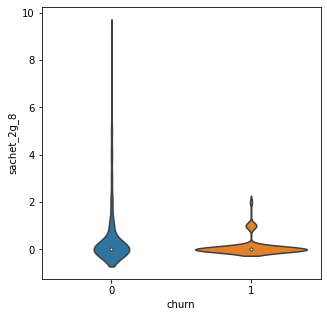

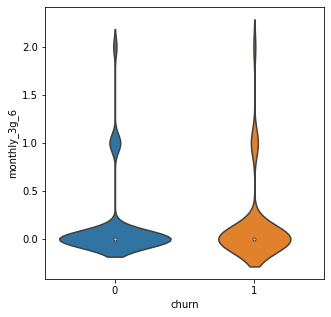

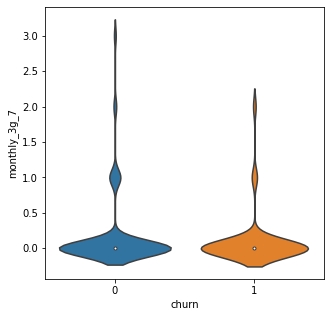

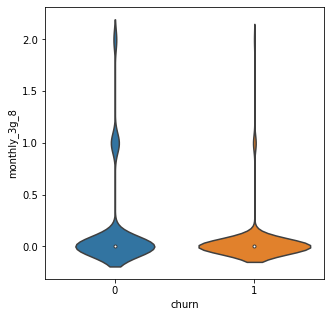

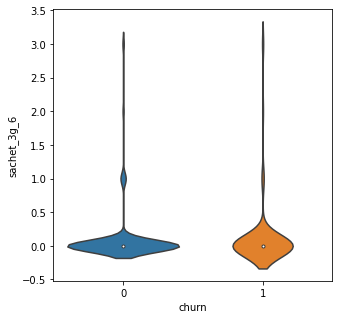

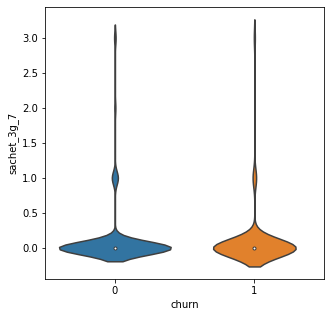

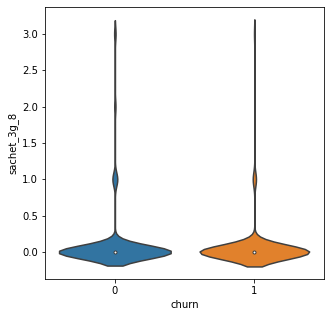

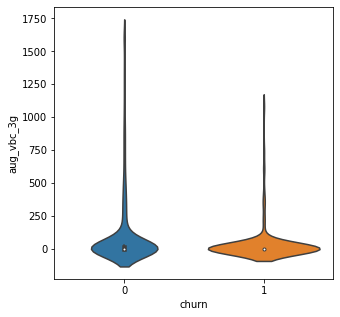

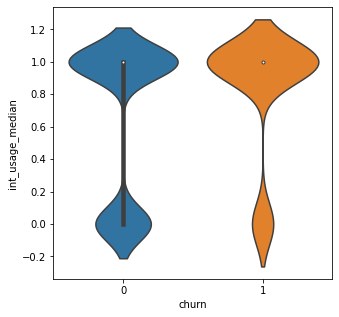

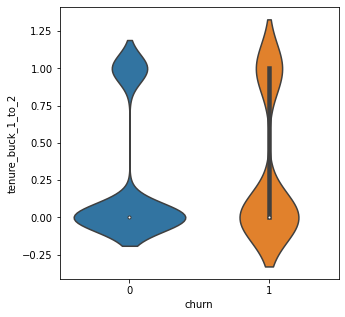

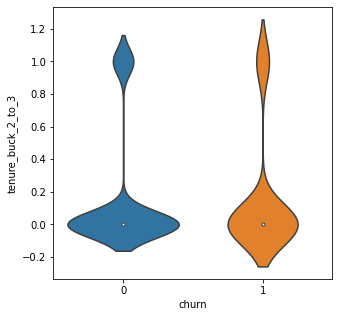

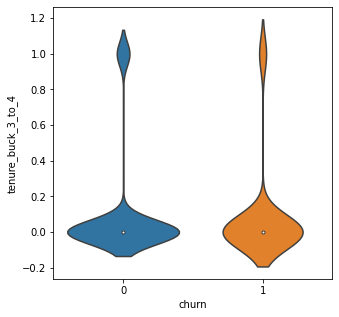

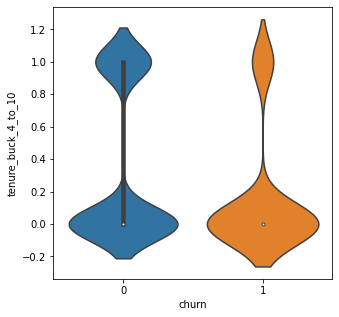

In [31]:
cont_cols = [col for col in telecom_df4.columns if col not in ['churn','mobile_number']]
for col in cont_cols:
    plt.figure(figsize=(5, 5))
    sns.violinplot(x='churn', y=col, data=telecom_df4)
    plt.show()

[Text(0, 0.5, '(%)')]

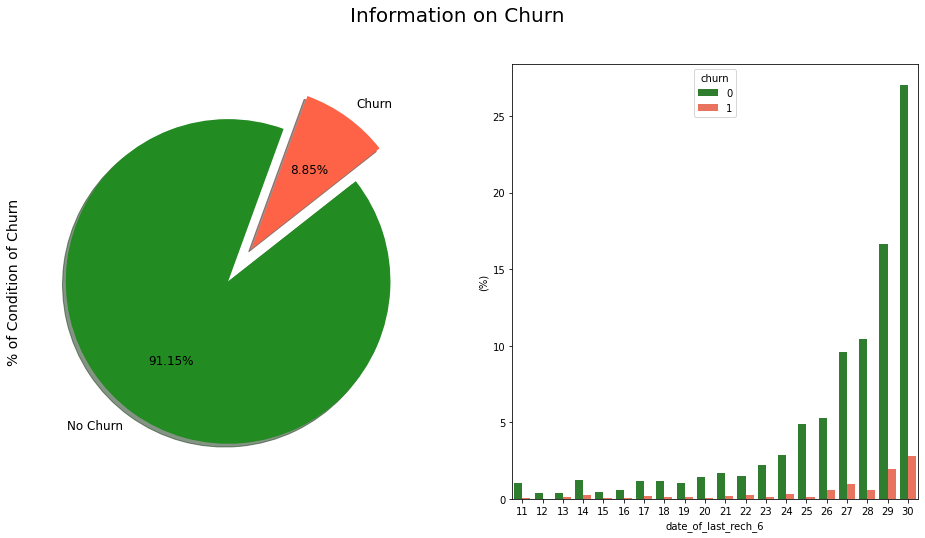

In [32]:
f, ax = plt.subplots(1,2, figsize=(16,8))
colors = ["#228B22", "#FF6347"]

labels ="No Churn", "Churn"
plt.suptitle('Information on Churn', fontsize=20)

telecom_df4["churn"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)
ax[0].set_ylabel('% of Condition of Churn', fontsize=14)

palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_6", y="churn", hue="churn", data=telecom_df4, palette=palette, estimator=lambda x: len(x) / len(telecom_df4) * 100)
ax[1].set(ylabel="(%)")

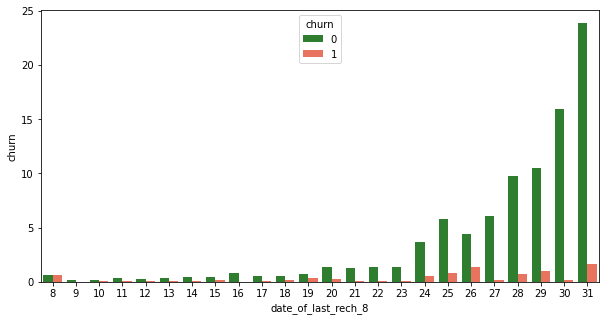

In [33]:
plt.figure(figsize=(10,5))
palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_8", y="churn", hue="churn", data=telecom_df4, palette=palette, 
            estimator=lambda x: len(x) / len(telecom_df4) * 100)

In [34]:
telecom_df4.shape

(1978, 65)

mobile_number    arpu_6  ...  tenure_buck_3_to_4  tenure_buck_4_to_10
7      7000701601  1069.180  ...                   0                    0
8      7001524846   378.721  ...                   0                    0
13     7002191713   492.846  ...                   0                    1
16     7000875565   430.975  ...                   0                    0
17     7000187447   690.008  ...                   0                    0

[5 rows x 65 columns]

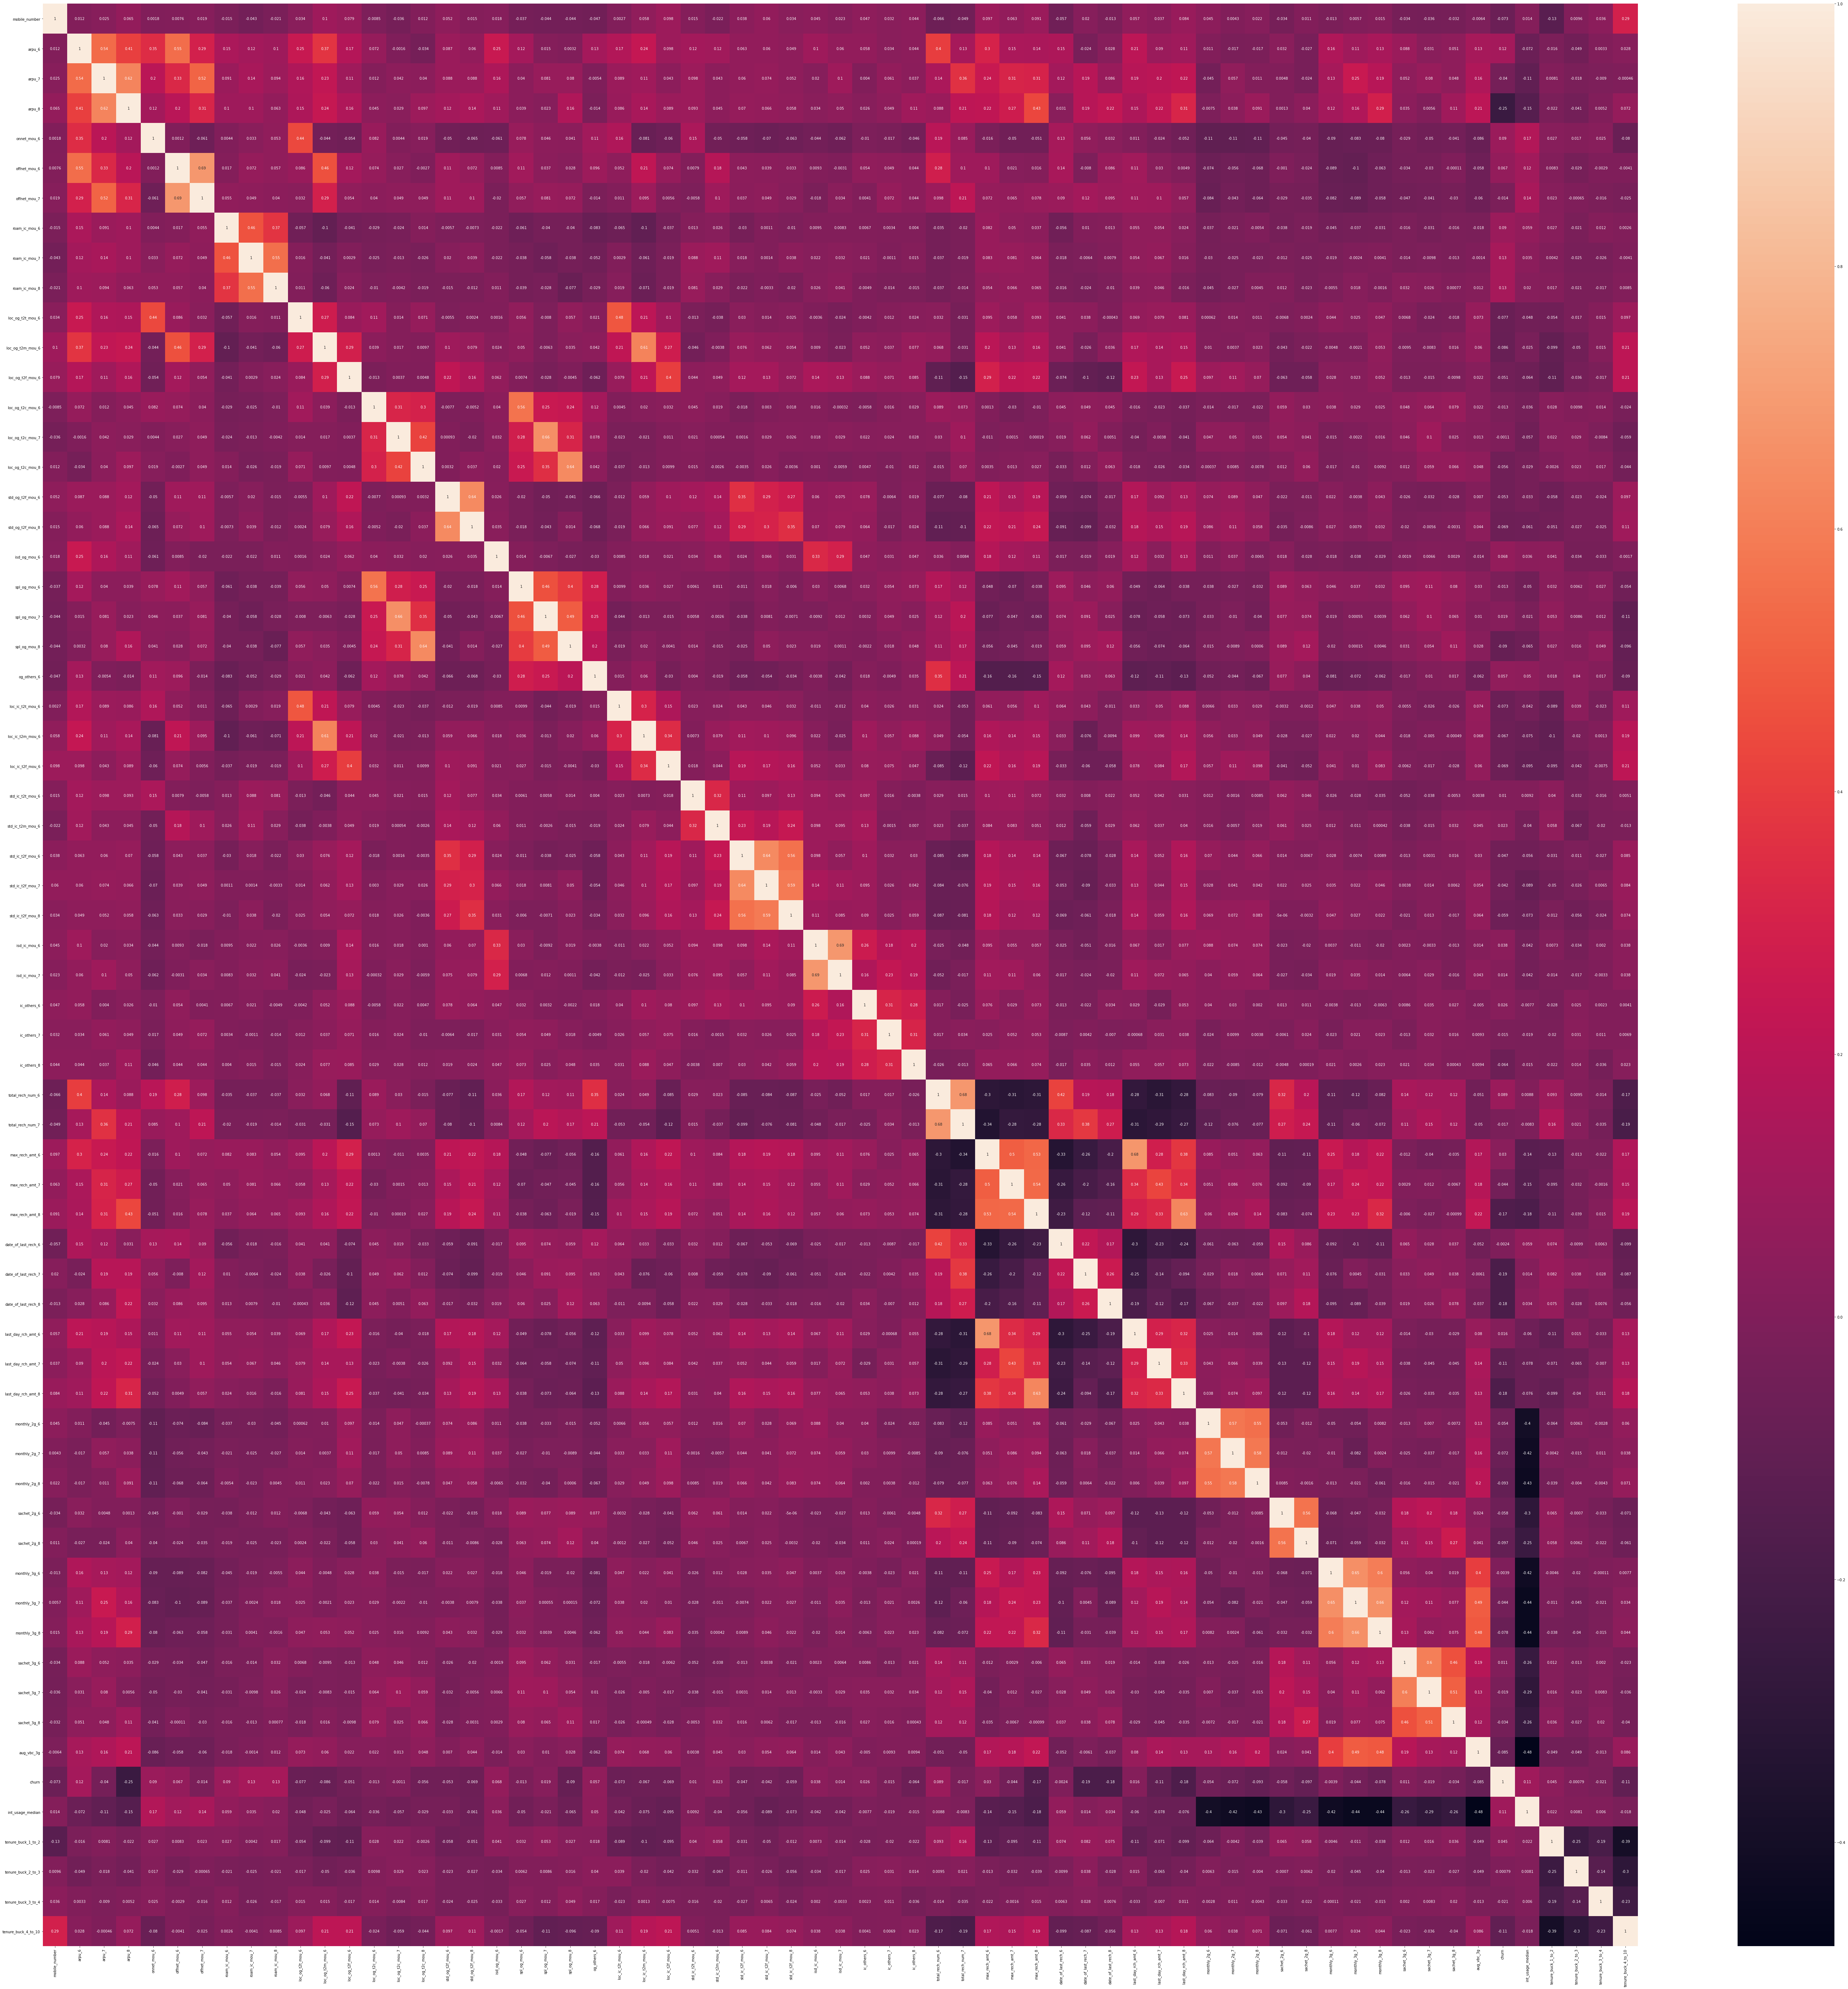

In [35]:
# Let's see the correlation matrix 
plt.figure(figsize = (100,100))        # Size of the figure
sns.heatmap(telecom_df4.corr(),annot = True)
telecom_df5 = telecom_df4
telecom_df5.head()

### Model Building
#### Splitting Data into Training and Test Sets

In [36]:
from sklearn.model_selection import train_test_split

# Putting feature variable to X
X = telecom_df5.drop(['churn','mobile_number'],axis=1)

# Putting response variable to y
y = telecom_df5['churn']

# defining a normalisation function 
def normalize (x): 
    return ( (x-np.min(x))/ (max(x) - min(x)))
                                                                                          
# applying normalize ( ) to all columns 
X_norm = X.apply(normalize) 
X_norm.head()

arpu_6    arpu_7  ...  tenure_buck_3_to_4  tenure_buck_4_to_10
7   0.518169  0.669907  ...                 0.0                  0.0
8   0.180844  0.239176  ...                 0.0                  0.0
13  0.236600  0.095259  ...                 0.0                  1.0
16  0.206373  0.142569  ...                 0.0                  0.0
17  0.332924  0.001496  ...                 0.0                  0.0

[5 rows x 63 columns]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, train_size=0.7,test_size=0.3,random_state=100)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (1384, 63)
Number transactions y_train dataset:  (1384,)
Number transactions X_test dataset:  (594, 63)
Number transactions y_test dataset:  (594,)


In [38]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 123
Before OverSampling, counts of label '0': 1261 



In [39]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_test==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_test==0)))

Before OverSampling, counts of label '1': 52
Before OverSampling, counts of label '0': 542 



## PCA
### Seems There is a class imbalance in curn event rate
- We can add class_weight = 'balanced'
- Lets do PCA 

In [40]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [41]:
#Doing the PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [42]:
print(pca.components_)
colnames = list(X_train.columns)
# pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
# pcs_df.head(10)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 
                       'PC3':pca.components_[2],'PC4':pca.components_[3],
                       'PC5':pca.components_[4],'PC6':pca.components_[5],
                       'PC7':pca.components_[6],'PC8':pca.components_[7],
                       'PC9':pca.components_[8],'PC10':pca.components_[9],
                       'Feature':colnames})
pcs_df.head(10)

[[ 3.31053595e-02  4.47379469e-02  8.02878111e-02 ... -1.18328190e-01
  -2.72650255e-02  5.39111521e-01]
 [ 1.85472144e-02  4.24018381e-02  3.61899783e-02 ...  6.51199421e-02
   4.33838974e-02 -5.42662213e-01]
 [-2.57378713e-02 -2.50077620e-02 -3.47487297e-02 ...  6.82608181e-01
   1.34501684e-01 -2.79878038e-01]
 ...
 [ 4.06849125e-02  1.33628544e-02  5.26969685e-02 ...  3.98297407e-04
   5.66601243e-04  8.55471889e-03]
 [ 1.43392449e-01  2.62709573e-01 -8.72714358e-02 ...  8.78559915e-03
   5.93162087e-03  5.83147349e-03]
 [-5.74140874e-01  4.82410777e-01  3.93530310e-02 ...  2.12912429e-04
   5.39511952e-03  5.98175938e-03]]


PC1       PC2       PC3  ...       PC9      PC10           Feature
0  0.033105  0.018547 -0.025738  ... -0.002576 -0.118753            arpu_6
1  0.044738  0.042402 -0.025008  ... -0.166419  0.158285            arpu_7
2  0.080288  0.036190 -0.034749  ... -0.213979  0.240915            arpu_8
3 -0.062132 -0.021228  0.007736  ... -0.208742 -0.115483       onnet_mou_6
4 -0.018822 -0.027390 -0.030063  ...  0.093574 -0.079373      offnet_mou_6
5 -0.020398 -0.025375 -0.021654  ... -0.025580  0.123812      offnet_mou_7
6 -0.008617 -0.003440 -0.015102  ... -0.080566  0.156211     roam_ic_mou_6
7  0.001732 -0.003706 -0.010609  ... -0.053966  0.159486     roam_ic_mou_7
8 -0.003660  0.007188 -0.014956  ... -0.073660  0.123664     roam_ic_mou_8
9  0.035159 -0.010331  0.003617  ... -0.104387 -0.199279  loc_og_t2t_mou_6

[10 rows x 11 columns]

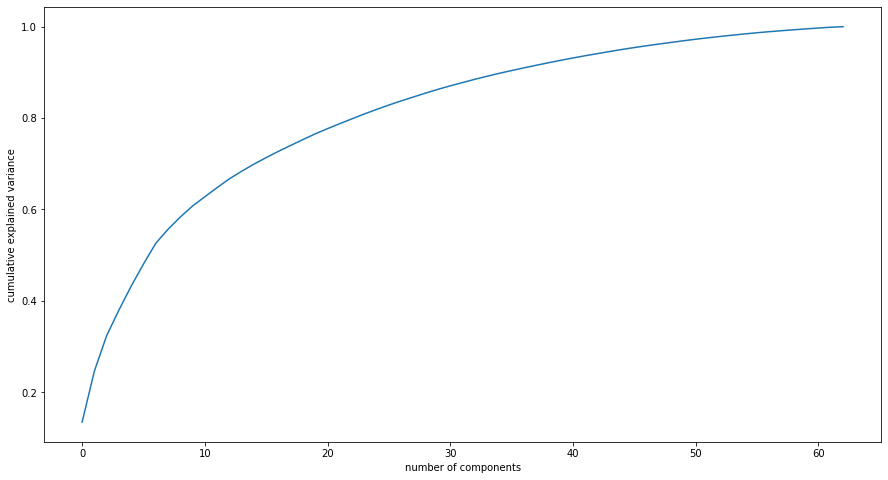

In [43]:
%matplotlib inline
fig = plt.figure(figsize = (15,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#### As we can see 40 component explain 90% of variance in the data

In [44]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=40)

df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(1384, 40)

### Correlation matrix

In [45]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())


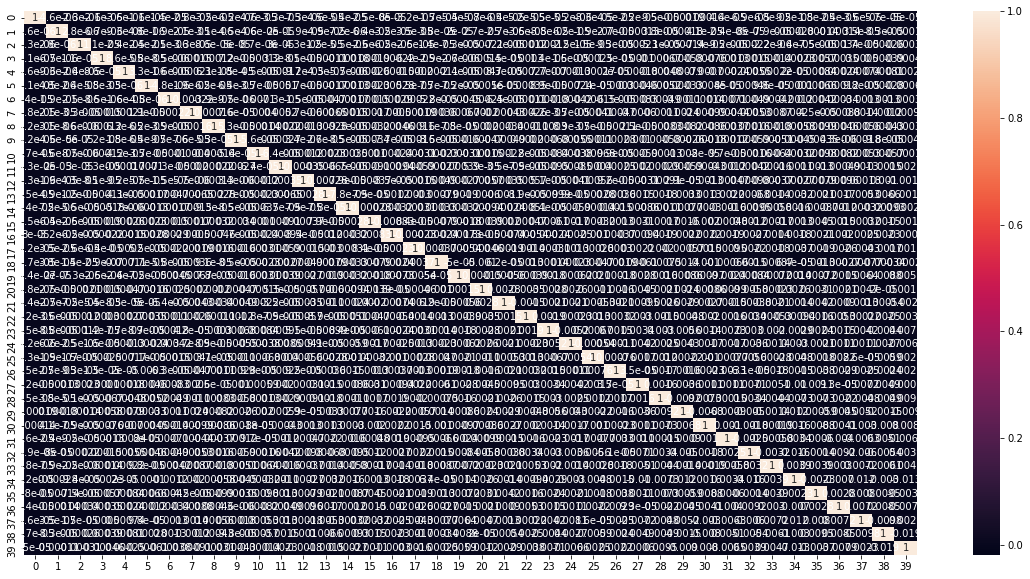

In [46]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [47]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.012160860812726895 , min corr:  -0.018922545620950082


In [48]:
#Applying selected components to the test data - 20 components
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(594, 40)

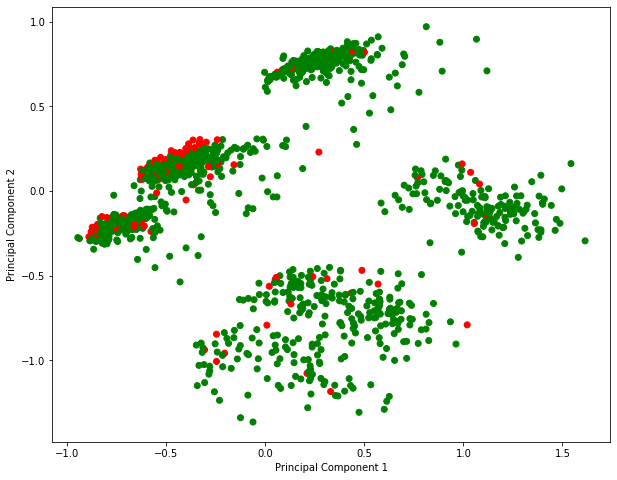

In [49]:
fig = plt.figure(figsize = (10,8))
plt.scatter(df_train_pca[:,0], df_train_pca[:,1], c = y_train.map({0:'green',1:'red'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### LogisticRegression model with PCA
- Now lets do the modeling with selected 40 pca feature 
- We also needs to do the class imbalance with class_width = balanced

In [50]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

learner_pca = LogisticRegression(class_weight='balanced')
model_pca = learner_pca.fit(df_train_pca,y_train)

- Making prediction on the test data

In [51]:
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.87'

In [52]:
#Making prediction on the test data
pred_test = model_pca.predict_proba(df_test_pca)
y_pred_default = model_pca.predict(df_test_pca)

In [53]:
# print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print(accuracy_score(y_test,y_pred_default))

[[452  90]
 [ 10  42]]
0.8316498316498316


In [54]:
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(pred_test)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test,y_pred_1],axis=1)

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'churn_prob'})


In [55]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(y_pred_final.churn,y_pred_final.churn_prob)
roc_auc = auc(fpr, tpr)
print('ROC_AUC score: ',roc_auc)

ROC_AUC score:  0.8654555776326994


## ROC Curve

In [56]:
#ROC Curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

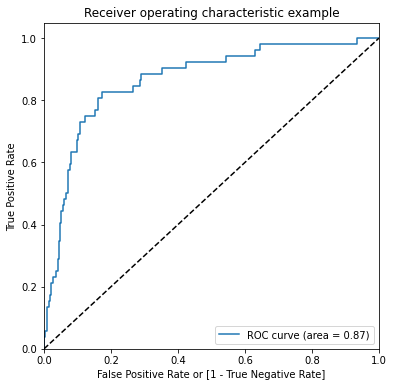

(array([0.        , 0.        , 0.        , 0.00184502, 0.00369004,
        0.00369004, 0.00553506, 0.00738007, 0.00738007, 0.00922509,
        0.00922509, 0.00922509, 0.00922509, 0.01107011, 0.01291513,
        0.01476015, 0.01476015, 0.01660517, 0.01660517, 0.01845018,
        0.0202952 , 0.02214022, 0.02214022, 0.02214022, 0.02398524,
        0.02583026, 0.02583026, 0.02767528, 0.0295203 , 0.03136531,
        0.03321033, 0.03505535, 0.03505535, 0.03690037, 0.03874539,
        0.04059041, 0.04243542, 0.04243542, 0.04243542, 0.04428044,
        0.04428044, 0.04428044, 0.04428044, 0.04612546, 0.04612546,
        0.04612546, 0.04612546, 0.04797048, 0.0498155 , 0.0498155 ,
        0.05166052, 0.05166052, 0.05350554, 0.05535055, 0.05719557,
        0.05719557, 0.05904059, 0.05904059, 0.06088561, 0.06273063,
        0.06457565, 0.06457565, 0.06642066, 0.06826568, 0.0701107 ,
        0.0701107 , 0.0701107 , 0.0701107 , 0.07195572, 0.07195572,
        0.07380074, 0.07564576, 0.07749077, 0.07

In [57]:
draw_roc(y_pred_final.churn, y_pred_final.churn_prob)

In [58]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.churn_prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

churn  churn_prob  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0      0    0.087044    1    0    0    0    0    0    0    0    0    0
1      0    0.555479    1    1    1    1    1    1    0    0    0    0
2      0    0.024382    1    0    0    0    0    0    0    0    0    0
3      0    0.329314    1    1    1    1    0    0    0    0    0    0
4      0    0.208125    1    1    1    0    0    0    0    0    0    0

- Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.

In [59]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.087542  0.000000  1.000000
0.1   0.1  0.350168  0.289668  0.980769
0.2   0.2  0.533670  0.496310  0.923077
0.3   0.3  0.676768  0.656827  0.884615
0.4   0.4  0.782828  0.778598  0.826923
0.5   0.5  0.831650  0.833948  0.807692
0.6   0.6  0.865320  0.878229  0.730769
0.7   0.7  0.892256  0.916974  0.634615
0.8   0.8  0.898990  0.939114  0.480769
0.9   0.9  0.909091  0.974170  0.230769


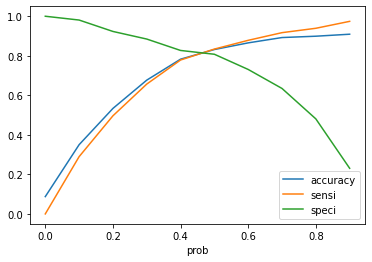

In [60]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [61]:
## Finidng the optimal cutoff
import sys
def Find_Optimal_Cutoff(target, predicted):

    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(y_pred_final.churn,y_pred_final.churn_prob)
print('Threshold: ',threshold)

Threshold:  [0.4870946458641078]


- Creating new column 'predicted' with 1 if Churn_Prob>0.49 else 0

In [62]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.49 else 0
y_pred_final['pred_churn'] = y_pred_final.churn_prob.map( lambda x: 1 if x > 0.49 else 0)

y_pred_final.churn.value_counts()

0    542
1     52
Name: churn, dtype: int64

### Confusion matrix 

In [63]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.pred_churn )
confusion

array([[449,  93],
       [ 10,  42]])

### Logistic Regression model matrics wit PCA -

In [64]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print('Accuracy Score on test data: ', accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score on test data:  0.8316498316498316
Sensitivity:  0.8076923076923077
Specificity:  0.8284132841328413
false postive rate:  0.17158671586715868
positive predictive value:  0.3111111111111111
Negative predictive value:  0.9782135076252724
Misclassification Rate:  0.1734006734006734


## LogistcRegression model with RFE
- As we have seen with PCA we select 40 component.
- We are selecting 10 feature from RFE

In [65]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced')
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 10)             # running RFE with 40 variables as output as PCA gave 40
rfe = rfe.fit(X_norm,y)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)           # Printing the ranking

[ True False  True False False False False False  True False False False
 False False False False  True  True False False False False  True False
 False False False False False False False False False False False False
 False False False False False False  True False  True  True False False
 False False  True False False False False False False False False False
 False False False]
[ 1  2  1 19 18 42 47 13  1  4  8 32 36 49 50  9  1  1 35 27 14 43  1 46
 37 38 52 39 40 29 11 33 20 54 23 22 41  5 15 48 21  3  1  6  1  1 28 45
 12  7  1 17 53 10 25 26 44 24 34 51 31 30 16]


In [66]:
col = X_train.columns[rfe.support_]
col

Index(['arpu_6', 'arpu_8', 'roam_ic_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_6',
       'loc_ic_t2t_mou_6', 'date_of_last_rech_8', 'last_day_rch_amt_7',
       'last_day_rch_amt_8', 'sachet_2g_8'],
      dtype='object')

In [67]:
import statsmodels.api as sm
# UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

### Correlation matrix

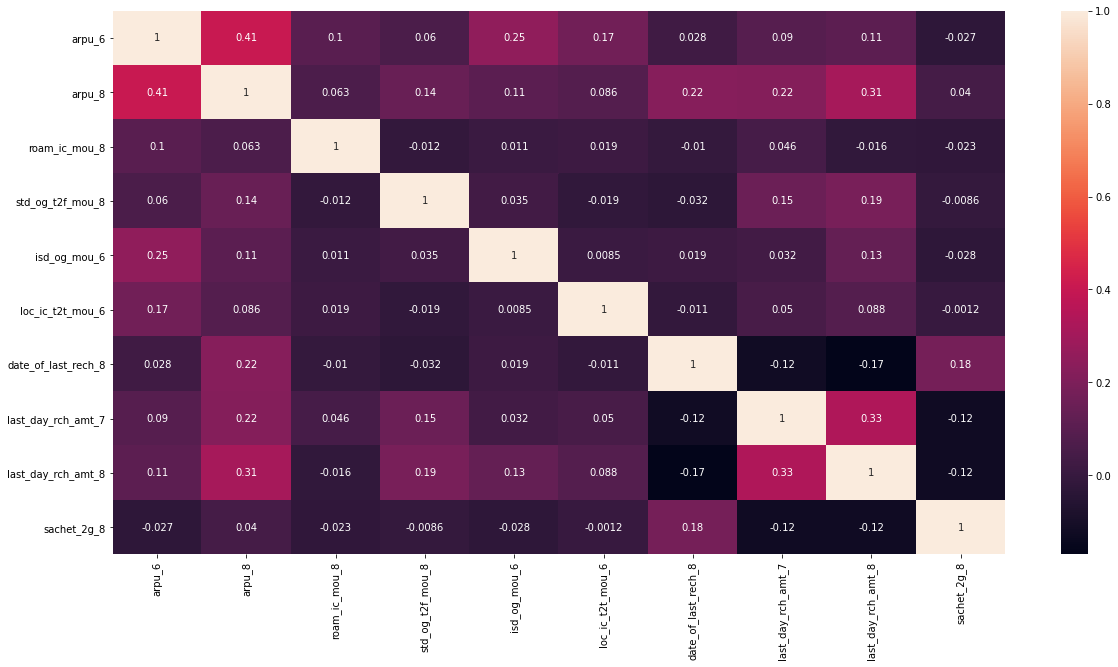

In [68]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(X_norm[col].corr(),annot = True)

### VIF value

In [69]:
col_for_vif = list(col)
col_for_vif.append('churn')
# telecom_df4.head()
vif_cal(input_data=telecom_df4[col_for_vif], dependent_col='churn')

Var   Vif
6  date_of_last_rech_8  5.26
0               arpu_6  4.93
1               arpu_8  4.46
7   last_day_rch_amt_7  2.20
8   last_day_rch_amt_8  2.12
5     loc_ic_t2t_mou_6  1.43
9          sachet_2g_8  1.21
3     std_og_t2f_mou_8  1.12
4         isd_og_mou_6  1.11
2        roam_ic_mou_8  1.10

- VIF looks good now will select these coloum for creating LogisticRegression

In [70]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(class_weight='balanced')
logsk.fit(X_train[col], y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### ROC_AUC score

In [71]:
#Making prediction on the test data
pred_probs_test = logsk.predict_proba(X_test[col])[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.87'

In [72]:
#Making prediction on the test data
pred_test = logsk.predict_proba(X_test[col])
y_pred_default = logsk.predict(X_test[col])

In [73]:
print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print('accuracy_score : ',accuracy_score(y_test,y_pred_default))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89       542
           1       0.30      0.81      0.44        52

    accuracy                           0.82       594
   macro avg       0.64      0.81      0.67       594
weighted avg       0.92      0.82      0.85       594

[[445  97]
 [ 10  42]]
accuracy_score :  0.8198653198653199


In [74]:
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(pred_test)

# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test,y_pred_1],axis=1)

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'churn_prob'})

In [75]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(y_pred_final.churn,y_pred_final.churn_prob)
roc_auc = auc(fpr, tpr)
print('ROC_AUC Score: ',roc_auc)

ROC_AUC Score:  0.8679392563156402


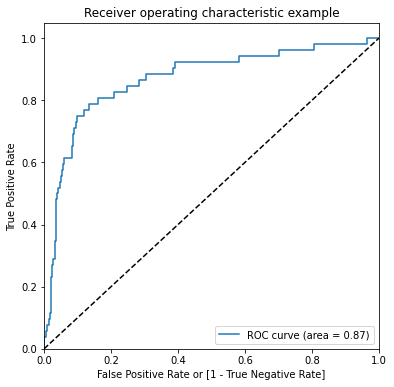

(array([0.        , 0.        , 0.        , 0.00184502, 0.00369004,
        0.00553506, 0.00553506, 0.00738007, 0.00738007, 0.00922509,
        0.01107011, 0.01291513, 0.01476015, 0.01476015, 0.01660517,
        0.01845018, 0.01845018, 0.0202952 , 0.02214022, 0.02214022,
        0.02214022, 0.02214022, 0.02214022, 0.02214022, 0.02214022,
        0.02398524, 0.02398524, 0.02398524, 0.02583026, 0.02767528,
        0.02767528, 0.0295203 , 0.03136531, 0.03136531, 0.03321033,
        0.03321033, 0.03321033, 0.03505535, 0.03505535, 0.03505535,
        0.03690037, 0.03690037, 0.03690037, 0.03690037, 0.03690037,
        0.03690037, 0.03874539, 0.03874539, 0.04059041, 0.04059041,
        0.04243542, 0.04428044, 0.04612546, 0.04797048, 0.04797048,
        0.0498155 , 0.05166052, 0.05166052, 0.05350554, 0.05350554,
        0.05535055, 0.05719557, 0.05719557, 0.05904059, 0.05904059,
        0.06088561, 0.06273063, 0.06457565, 0.06642066, 0.06826568,
        0.0701107 , 0.07195572, 0.07380074, 0.07

In [76]:
draw_roc(y_pred_final.churn, y_pred_final.churn_prob)

In [77]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.churn_prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()


churn  churn_prob  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0      0    0.304799    1    1    1    1    0    0    0    0    0    0
1      0    0.528381    1    1    1    1    1    1    0    0    0    0
2      0    0.141833    1    1    0    0    0    0    0    0    0    0
3      0    0.370835    1    1    1    1    0    0    0    0    0    0
4      0    0.279194    1    1    1    0    0    0    0    0    0    0

In [78]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.087542  0.000000  1.000000
0.1   0.1  0.281145  0.215867  0.961538
0.2   0.2  0.436027  0.387454  0.942308
0.3   0.3  0.601010  0.570111  0.923077
0.4   0.4  0.730640  0.719557  0.846154
0.5   0.5  0.819865  0.821033  0.807692
0.6   0.6  0.880471  0.892989  0.750000
0.7   0.7  0.904040  0.931734  0.615385
0.8   0.8  0.917508  0.963100  0.442308
0.9   0.9  0.905724  0.983395  0.096154


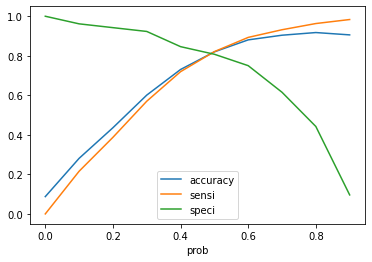

In [79]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [80]:
## Finidng the optimal cutoff
def Find_Optimal_Cutoff(target, predicted):

    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(y_pred_final.churn,y_pred_final.churn_prob)
print('CutOff threshold: ', threshold)

CutOff threshold:  [0.4606181653487635]


In [81]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.49 else 0
y_pred_final['pred_churn'] = y_pred_final.churn_prob.map( lambda x: 1 if x > 0.49 else 0)

y_pred_final.churn.value_counts()


0    542
1     52
Name: churn, dtype: int64

In [82]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.pred_churn )
confusion

array([[439, 103],
       [ 10,  42]])

In [83]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print('Accuracy Score : ',accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

Accuracy Score :  0.8198653198653199
Sensitivity:  0.8076923076923077
Specificity:  0.8099630996309963
false postive rate:  0.1900369003690037
positive predictive value:  0.2896551724137931
Negative predictive value:  0.977728285077951


#### As we can see Above LogisticRegression giving good Accuracy with PCA and with RFE

### With PCA
- Accuracy Score on test data:  0.8110962864131643
- Sensitivity:  0.8098159509202454
- Specificity:  0.8057219709010881
- false postive rate:  0.19427802909891184
- positive predictive value:  0.2934637616718542
- Negative predictive value:  0.9770200148257969
- Misclassification Rate:  0.1939070491438737

#### With RFE
- Accuracy Score :  0.811985768289971
- Sensitivity:  0.8122699386503067
- Specificity:  0.8049883848881282
- false postive rate:  0.19501161511187187
- positive predictive value:  0.2933097031457687
- Negative predictive value:  0.9772895947751224


## SVM with PCA

In [84]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]


# specify model
model = SVC(kernel="linear", class_weight='balanced')

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,n_jobs=-1,
                        return_train_score=True)

In [85]:
# fit the model
model_cv.fit(df_train_pca,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   40.5s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [86]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',model_cv.best_score_,'using',model_cv.best_params_)

We can get accuracy of 0.8164730811489562 using {'C': 1000, 'gamma': 0.01}


In [87]:
# upon trying rbf, poly and linear. Linear is giving the best results.
model = SVC(C=1000, gamma=0.01, kernel="linear", class_weight='balanced')
model.fit(df_train_pca,y_train)
y_pred_default = model.predict(df_test_pca)

confusion_SVM_hyper=confusion_matrix(y_test,y_pred_default)
confusion_SVM_hyper

array([[454,  88],
       [ 10,  42]])

## DecisionTreeClassifier With PCA

In [88]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=5, class_weight='balanced')
dt_default.fit(df_train_pca,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [89]:
# Let's check the evaluation metrics of our default model

# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred_default = dt_default.predict(df_test_pca)

# # Printing classification report
# print(classification_report(y_test, y_pred_default))

# from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print('Acuracy Score', accuracy_score(y_test,y_pred_default))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       542
           1       0.21      0.58      0.30        52

    accuracy                           0.77       594
   macro avg       0.58      0.68      0.58       594
weighted avg       0.89      0.77      0.81       594

[[426 116]
 [ 22  30]]
Acuracy Score 0.7676767676767676


In [90]:
confusion_tree = confusion_matrix(y_test,y_pred_default)
TP = confusion_tree[1,1] # true positive 
TN = confusion_tree[0,0] # true negatives
FP = confusion_tree[0,1] # false positives
FN = confusion_tree[1,0] # false negatives

print('Acuracy Score', accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Acuracy Score 0.7676767676767676
Sensitivity:  0.5769230769230769
Specificity:  0.7859778597785978
false postive rate:  0.2140221402214022
positive predictive value:  0.2054794520547945
Negative predictive value:  0.9508928571428571
Misclassification Rate:  0.23232323232323232


- As we can see above Sensitivity of model is not great let's tune the Hyperparameter

## Hyperparameter tuning

In [91]:
########## lets tune hyper parameterss
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", class_weight='balanced', random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", 
                    return_train_score=True)

tree.fit(df_train_pca,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=100,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'m

In [92]:
y_train.shape

(1384,)

In [93]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.005888      0.000848  ...          0.781614         0.037974
1       0.009479      0.000128  ...          0.793159         0.130023
2       0.013184      0.000105  ...          0.800380         0.058409
3       0.016780      0.000265  ...          0.817548         0.044573
4       0.019436      0.000608  ...          0.867586         0.042727

[5 rows x 21 columns]

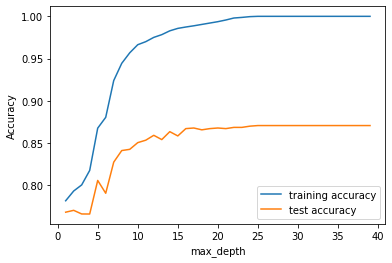

In [94]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# seems 15 or 20 Max depth

In [95]:
## Lets tune min sample leaf
# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini",class_weight='balanced',random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                    return_train_score=True)
tree.fit(df_train_pca,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=100,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'m

In [96]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.023446      0.002126  ...          0.940028         0.003423
1       0.018793      0.001357  ...          0.798227         0.023297
2       0.016576      0.001143  ...          0.763362         0.030516
3       0.015251      0.000791  ...          0.765528         0.029063
4       0.014477      0.001409  ...          0.769324         0.033494

[5 rows x 21 columns]

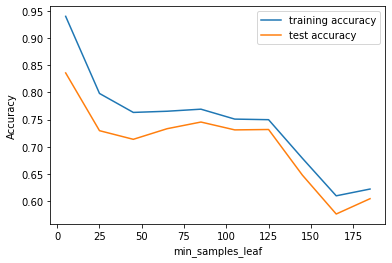

In [97]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#seems 5 to 150

In [98]:
## Tuning min sample split
# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini",class_weight='balanced', random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                    return_train_score=True)
tree.fit(df_train_pca,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=100,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'m

In [99]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.029087      0.003554  ...          0.995665         0.002880
1       0.026974      0.002539  ...          0.910586         0.010024
2       0.026128      0.002653  ...          0.849528         0.019677
3       0.025068      0.002258  ...          0.812858         0.017280
4       0.021661      0.001906  ...          0.778353         0.040526

[5 rows x 21 columns]

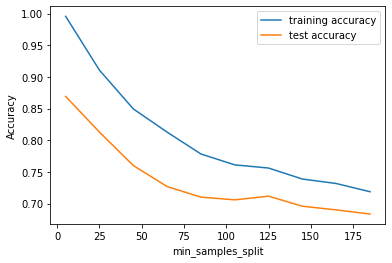

In [100]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#seems 25

In [101]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(5, 200, 20),
    'min_samples_split': range(5, 200, 20),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier(class_weight='balanced')
grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           refit='recall_score',
                          cv = n_folds, verbose = 1, 
                           n_jobs = -1,
                           return_train_score=True)

# Fit the grid search to the data
grid_search.fit(df_train_pca,y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   29.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'cr

In [102]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.058976      0.003725  ...          0.827315         0.054276
1       0.054046      0.001088  ...          0.818465         0.055598
2       0.052009      0.001888  ...          0.794981         0.053040
3       0.051455      0.003354  ...          0.780708         0.048085
4       0.049486      0.002702  ...          0.784500         0.049415

[5 rows x 24 columns]

In [103]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.8316538481661697
DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')


In [104]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini",class_weight='balanced',
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=5,
                                  min_samples_split=5)
clf_gini.fit(df_train_pca,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

In [105]:
y_pred_default = clf_gini.predict(df_test_pca)
confusion_tree_hyper=confusion_matrix(y_test,y_pred_default)
confusion_tree_hyper

array([[463,  79],
       [ 35,  17]])

In [106]:
TP = confusion_tree_hyper[1,1] # true positive 
TN = confusion_tree_hyper[0,0] # true negatives
FP = confusion_tree_hyper[0,1] # false positives
FN = confusion_tree_hyper[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Sensitivity:  0.3269230769230769
Specificity:  0.8542435424354243
false postive rate:  0.14575645756457564
positive predictive value:  0.17708333333333334
Negative predictive value:  0.929718875502008
Misclassification Rate:  0.1919191919191919


## RandomForestClassifier with PCA

In [107]:
# Random forest

# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier(class_weight='balanced')

# fit
rfc.fit(df_train_pca,y_train)

# Making predictions
y_pred_default = rfc.predict(df_test_pca)

In [108]:
confusion_rf=confusion_matrix(y_test,y_pred_default)
confusion_rf

array([[541,   1],
       [ 48,   4]])

In [109]:
TN = confusion_rf[0,0] # true positive 
TP = confusion_rf[1,1] # true negatives
FP = confusion_rf[0,1] # false positives
FN = confusion_rf[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Sensitivity:  0.07692307692307693
Specificity:  0.9981549815498155
false postive rate:  0.0018450184501845018
positive predictive value:  0.8
Negative predictive value:  0.9185059422750425
Misclassification Rate:  0.08249158249158249


### Hyperparameter tuning for RandomForest

In [110]:
#Lets do some hyper parameter tuning 
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5
# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf_with_pca = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf_with_pca = GridSearchCV(rf_with_pca, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", n_jobs=-1,
                   return_train_score=True)

rf_with_pca.fit(df_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [111]:
# scores of GridSearch CV
scores = rf_with_pca.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.303478      0.004304  ...          0.910043         0.006413
1       0.497808      0.011138  ...          0.995304         0.001552
2       0.513063      0.007417  ...          0.999458         0.000723
3       0.504493      0.020354  ...          1.000000         0.000000

[4 rows x 21 columns]

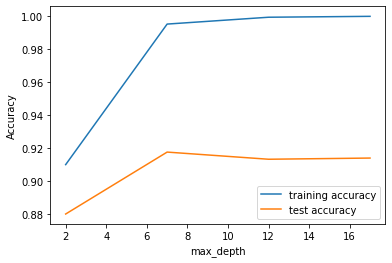

In [112]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#seems 10 to 12

In [113]:
# Tuning n_estimators
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", n_jobs=-1,
                  return_train_score=True)

rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              r

In [114]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.509841      0.008381  ...          0.999097         0.000808
1       2.549587      0.034546  ...          0.998916         0.000676
2       4.579273      0.055515  ...          0.998736         0.000722
3       6.315633      0.535955  ...          0.999097         0.000571

[4 rows x 21 columns]

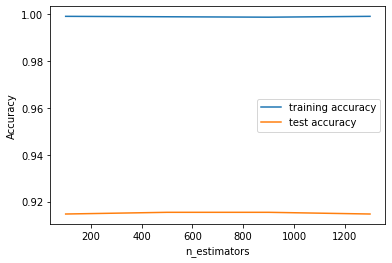

In [115]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [116]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=10,class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", n_jobs=-1,
                  return_train_score=True)

rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              r

In [117]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.417570      0.006089  ...          0.999458         0.000723
1       0.616391      0.017514  ...          0.998736         0.000722
2       0.885807      0.011796  ...          0.998194         0.001142
3       1.152084      0.020571  ...          0.998013         0.001053
4       1.273790      0.107771  ...          0.995665         0.002703

[5 rows x 21 columns]

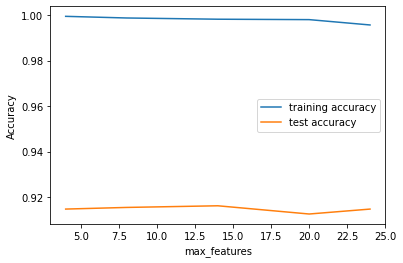

In [118]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 8 to 10

In [119]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", n_jobs=-1,
                  return_train_score=True)

rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [120]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.323719      0.011877  ...          0.887465         0.007686
1       0.289158      0.005492  ...          0.860909         0.007298
2       0.259240      0.002892  ...          0.838692         0.016410
3       0.237080      0.007005  ...          0.807624         0.011583
4       0.234435      0.003279  ...          0.793530         0.018954

[5 rows x 21 columns]

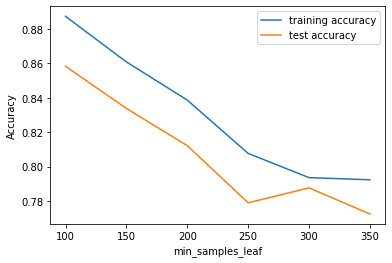

In [121]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#seems 100 to 150

In [122]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)

rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [123]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.253928      0.006105  ...          0.914015         0.008067
1       0.239383      0.008126  ...          0.898120         0.008083
2       0.218123      0.003723  ...          0.892339         0.006966
3       0.203628      0.003458  ...          0.887102         0.007886
4       0.191265      0.003508  ...          0.869763         0.006820

[5 rows x 21 columns]

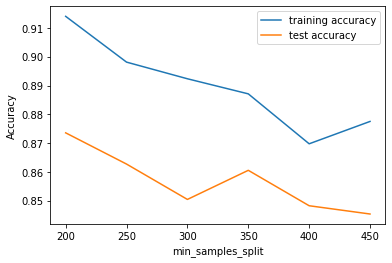

In [124]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 200 to 300

In [125]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [8,10],
    'min_samples_leaf': range(100, 200, 100),
    'min_samples_split': range(200, 400, 100),
    'n_estimators': range(200, 400, 100), 
    'max_features': [8, 10, 12]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,refit='recall_score' ,
                          cv = 5, n_jobs=-1, verbose = 1)

In [126]:
# Fit the grid search to the data
grid_search.fit(df_train_pca, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   59.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs...
                                              oob_score=False,
                                              ra

In [127]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8547690053890022 using {'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 300}


In [128]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=8,
                             n_estimators=300)

In [129]:
# fit
rfc.fit(df_train_pca,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [130]:
# predict
y_pred_default = rfc.predict(df_test_pca)

In [131]:
print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print('accuracy_score:  ',accuracy_score(y_test,y_pred_default))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       542
           1       0.30      0.67      0.42        52

    accuracy                           0.84       594
   macro avg       0.63      0.76      0.66       594
weighted avg       0.91      0.84      0.86       594

[[462  80]
 [ 17  35]]
accuracy_score:   0.8367003367003367


In [132]:
# Confusion Matrix
confusion_rf_hyper=confusion_matrix(y_test,y_pred_default)
confusion_rf_hyper

array([[462,  80],
       [ 17,  35]])

In [133]:
TN = confusion_rf_hyper[0,0] # true positive 
TP = confusion_rf_hyper[1,1] # true negatives
FP = confusion_rf_hyper[0,1] # false positives
FN = confusion_rf_hyper[1,0] # false negatives

print('Accuracy Score:  ',accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score:   0.8367003367003367
Sensitivity:  0.6730769230769231
Specificity:  0.8523985239852399
false postive rate:  0.14760147601476015
positive predictive value:  0.30434782608695654
Negative predictive value:  0.964509394572025
Misclassification Rate:  0.1632996632996633


### Recomendation for Model Selection
- Logistic Regression and Random Forest performed better than Decision Tree for customer churn analysis for this particular dataset, using PCA.
- LogisticRegression is the best model 80.9% Sensitivity
- Accuracy of RandomForest is highest with 85%

#### LogisticRegression 
- Accuracy Score : 0.8110962864131643 (With PCA on Test)
- Sensitivity: 0.8098159509202454 (with PCA)

- Accuracy Score : 0.811985768289971 (With RFE on Test)
- Sensitivity: 0.8122699386503067 (with RFE)

#### RandomForest
- Accuracy Score:   0.8570157883033134
- Sensitivity:  0.6711656441717792

#### DecisionTree
- Sensitivity:  0.6233128834355828 (with PCA)

## RandomForest on all feature

In [134]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier(class_weight='balanced')

In [135]:
# fit
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [136]:
# Making predictions
predictions = rfc.predict(X_test)

In [137]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       542
           1       0.83      0.38      0.53        52

    accuracy                           0.94       594
   macro avg       0.89      0.69      0.75       594
weighted avg       0.93      0.94      0.93       594

[[538   4]
 [ 32  20]]
0.9393939393939394


In [138]:
# Confusion Matrix
confusion_rf_with_all_feature=confusion_matrix(y_test,predictions)
confusion_rf_with_all_feature

array([[538,   4],
       [ 32,  20]])

In [139]:
TN = confusion_rf_with_all_feature[0,0] # true positive 
TP = confusion_rf_with_all_feature[1,1] # true negatives
FP = confusion_rf_with_all_feature[0,1] # false positives
FN = confusion_rf_with_all_feature[1,0] # false negatives

print('Accuracy Score: ', accuracy_score(y_test,predictions))
# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score:  0.9393939393939394
Sensitivity:  0.38461538461538464
Specificity:  0.992619926199262
false postive rate:  0.007380073800738007
positive predictive value:  0.8333333333333334
Negative predictive value:  0.9438596491228071
Misclassification Rate:  0.06060606060606061


## Hyperparameter Tuning 

In [140]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds,
   scoring="accuracy",return_train_score=True)

In [141]:
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [142]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.149691      0.002941  ...          0.921965         0.003512
1       0.220976      0.003440  ...          0.987536         0.002089
2       0.229641      0.002538  ...          0.999458         0.000443
3       0.234379      0.004234  ...          1.000000         0.000000

[4 rows x 21 columns]

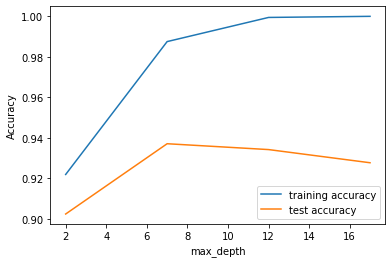

In [143]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#10,12

In [144]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1000, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", n_jobs=-1,
                  return_train_score=True)

rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              r

In [145]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.366232      0.009981  ...          0.997652         0.001859
1       1.796295      0.026723  ...          0.997291         0.001615
2       3.097558      0.224317  ...          0.997291         0.001895

[3 rows x 21 columns]

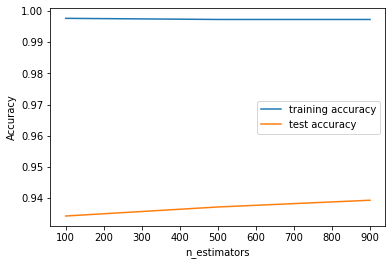

In [146]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [147]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)

rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              r

In [148]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.187511      0.001366  ...          0.997291         0.001511
1       0.240859      0.002351  ...          0.996387         0.001894
2       0.324489      0.007801  ...          0.995846         0.001674
3       0.405130      0.004659  ...          0.995846         0.001675
4       0.456687      0.007332  ...          0.994400         0.002091

[5 rows x 21 columns]

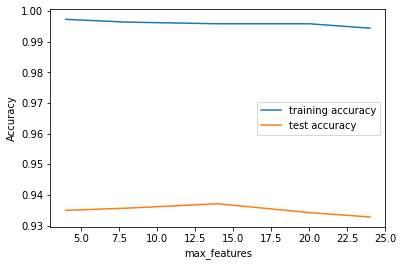

In [149]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [150]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)

rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [151]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.155382      0.002089  ...          0.885838         0.002894
1       0.147394      0.005198  ...          0.860549         0.007053
2       0.134986      0.002275  ...          0.827311         0.012933
3       0.125684      0.001637  ...          0.770949         0.013328
4       0.126318      0.004095  ...          0.765355         0.010779

[5 rows x 21 columns]

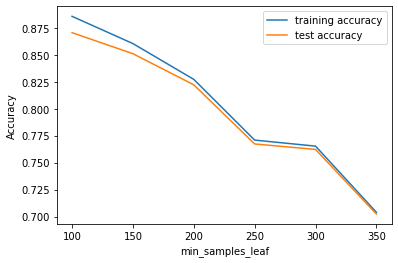

In [152]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [153]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(100, 700, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)

rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [154]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.200835      0.003301  ...          0.936596         0.005647
1       0.196058      0.005219  ...          0.927023         0.006137
2       0.190744      0.008590  ...          0.919255         0.006924
3       0.180696      0.004941  ...          0.912209         0.006789
4       0.174470      0.003029  ...          0.909680         0.007357

[5 rows x 21 columns]

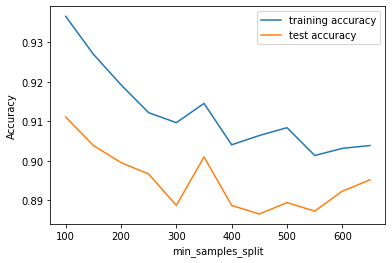

In [155]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [156]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10,12],
    'min_samples_leaf': range(150, 250, 50),
    'min_samples_split': range(200, 400, 100),
    'n_estimators': [300,400,500], 
    'max_features': [15, 20]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid,
                           refit='recall_score' ,
                          cv = 3, verbose = 1, 
                           n_jobs=-1,
                           return_train_score=True)

In [157]:
# fit
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

- printing the optimal accuracy score and hyperparameters

In [158]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8475458019926566 using {'max_depth': 12, 'max_features': 20, 'min_samples_leaf': 150, 'min_samples_split': 300, 'n_estimators': 500}


In [159]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc_final = RandomForestClassifier(bootstrap=True,class_weight='balanced',
                             max_depth=10,
                             min_samples_leaf=150, 
                             min_samples_split=300,
                             max_features=15,
                             n_estimators=500)

In [160]:
# fit
rfc_final.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features=15,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=150, min_samples_split=300,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [161]:
# predict
predictions = rfc_final.predict(X_test)

In [162]:
from sklearn import metrics
confusion_rm_f = metrics.confusion_matrix( y_test, predictions )
confusion_rm_f

array([[479,  63],
       [ 13,  39]])

In [163]:
TN = confusion_rm_f[0,0] # true positive 
TP = confusion_rm_f[1,1] # true negatives
FP = confusion_rm_f[0,1] # false positives
FN = confusion_rm_f[1,0] # false negatives

print('Accuracy Score: ',accuracy_score(y_test,predictions))
# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score:  0.8720538720538721
Sensitivity:  0.75
Specificity:  0.8837638376383764
false postive rate:  0.11623616236162361
positive predictive value:  0.38235294117647056
Negative predictive value:  0.9735772357723578
Misclassification Rate:  0.12794612794612795


### RandomForest model with All feature gives: 
- **87%** of Accuracy and **75%** of Sensitivity

In [164]:
#Important Variables
from collections import OrderedDict
feature_names=list(X_train.columns.values)
important_features_dict = {}
for name, importance in zip(feature_names, rfc_final.feature_importances_):
    important_features_dict[name]=importance
#Sorting Dictionary in descending order of the importance variable
d_descending = OrderedDict(sorted(important_features_dict.items(), 
                                  key=lambda kv: kv[1], reverse=True))

In [165]:
telecom_df5.columns

Index(['mobile_number', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       'offnet_mou_6', 'offnet_mou_7', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6',
       'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'loc_og_t2c_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_8',
       'isd_og_mou_6', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8',
       'og_others_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6',
       'loc_ic_t2f_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6',
       'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8',
       'isd_ic_mou_6', 'isd_ic_mou_7', 'ic_others_6', 'ic_others_7',
       'ic_others_8', 'total_rech_num_6', 'total_rech_num_7', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'date_of_last_rech_6',
       'date_of_last_rech_7', 'date_of_last_rech_8', 'last_day_rch_amt_6',
       'last_day_rch_amt_7', 'last_day_rch_amt_8', 'monthly_2g_6',
       'monthly_2g_7', 'monthly_2g_8

In [166]:
#Variable Importance top 30 variable
dic= dict(d_descending)

from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

n=12
n_items = take(n, dic.items())

In [167]:
print('These are top 12 driver variable: ',n_items)

These are top 12 driver variable:  [('last_day_rch_amt_8', 0.25928080182103824), ('arpu_8', 0.25580778575653007), ('max_rech_amt_8', 0.15521636860593194), ('date_of_last_rech_8', 0.05646323094558104), ('spl_og_mou_8', 0.036172606119924615), ('loc_ic_t2m_mou_6', 0.028155533091578897), ('last_day_rch_amt_7', 0.025495468505520227), ('roam_ic_mou_8', 0.021664196585266863), ('loc_og_t2m_mou_6', 0.020184798315137392), ('max_rech_amt_7', 0.017081342446287742), ('arpu_7', 0.015948651693033472), ('loc_ic_t2t_mou_6', 0.015614603951385465)]


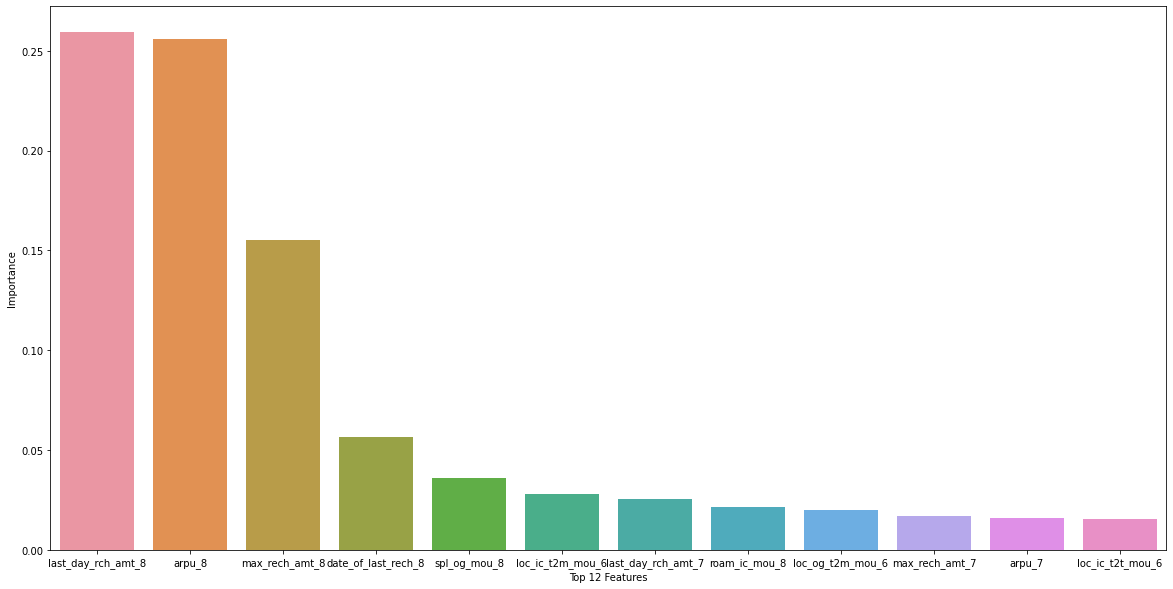

In [168]:
imp=rfc_final.feature_importances_
names=X_train.columns.values
imp,names=zip(*sorted(zip(imp,names)))

df_1=pd.DataFrame({"Variable":names,"importance":imp})
df_2 = df_1.sort_values(by="importance",axis=0,ascending=False)
df_2 = df_2.reset_index(drop=True)


plt.figure(figsize=(20, 10))

ax = sns.barplot(x='Variable', y= 'importance', data=df_2[0:12])
ax.set(xlabel = 'Top 12 Features', ylabel = 'Importance')
plt.show()

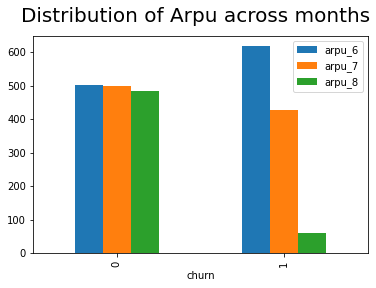

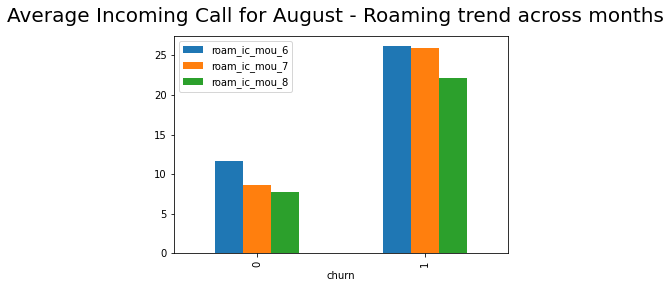

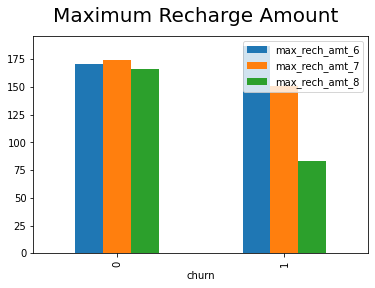

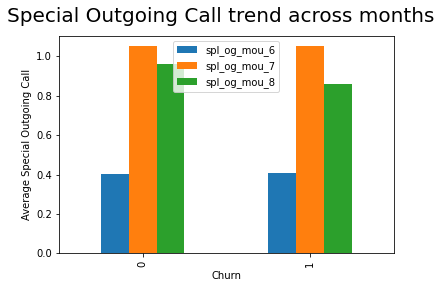

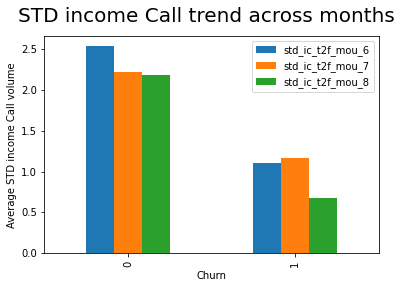

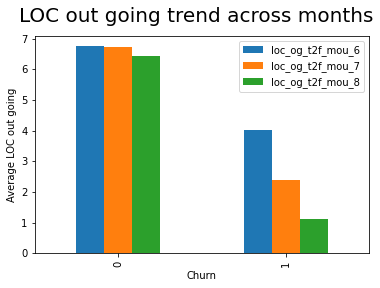

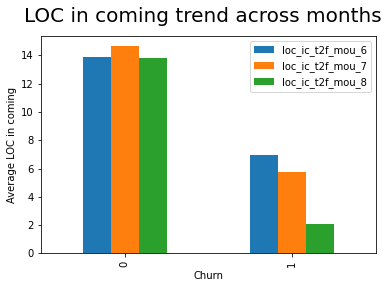

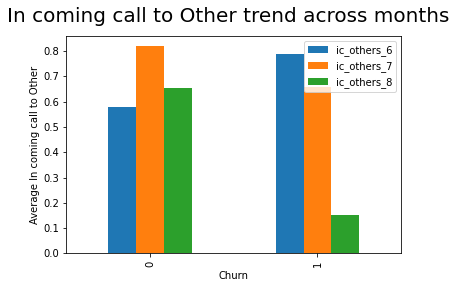

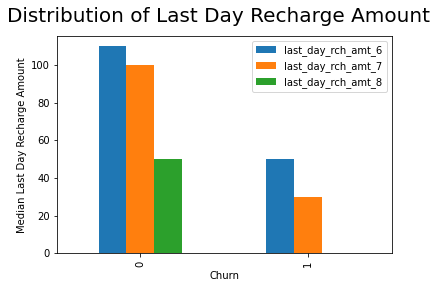

In [169]:
telecom_df2['churn'] = telecom_df2['churn'].astype('object', copy = False)
df_sample = telecom_df2.groupby(['churn'])['arpu_6', 'arpu_7', 'arpu_8'].median()
df_sample.plot.bar()
plt.suptitle('Distribution of Arpu across months', fontsize=20)
plt.show()

df_sample = telecom_df2.groupby(['churn'])['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('Average Incoming Call for August - Roaming trend across months', fontsize=20)
plt.show()

df_sample = telecom_df2.groupby(['churn'])['max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8'].mean()
df_sample.plot.bar()
plt.suptitle('Maximum Recharge Amount', fontsize=20)
plt.show()


df_sample = telecom_df2.groupby(['churn'])['spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8'].median()
df_sample.plot.bar()
plt.suptitle('Special Outgoing Call trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average Special Outgoing Call")
plt.show()


df_sample = telecom_df2.groupby(['churn'])['std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('STD income Call trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average STD income Call volume")
plt.show()


df_sample = telecom_df2.groupby(['churn'])['loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('LOC out going trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average LOC out going")
plt.show()

df_sample = telecom_df2.groupby(['churn'])['loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('LOC in coming trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average LOC in coming")
plt.show()

df_sample = telecom_df2.groupby(['churn'])['ic_others_6', 'ic_others_7', 'ic_others_8'].mean()
df_sample.plot.bar()
plt.suptitle('In coming call to Other trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average In coming call to Other")
plt.show()

telecom_df2['churn'] = telecom_df2['churn'].astype('object', copy = False)
df_sample = telecom_df2.groupby(['churn'])['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8'].median()
df_sample.plot.bar()
plt.suptitle('Distribution of Last Day Recharge Amount', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Median Last Day Recharge Amount")
plt.show()

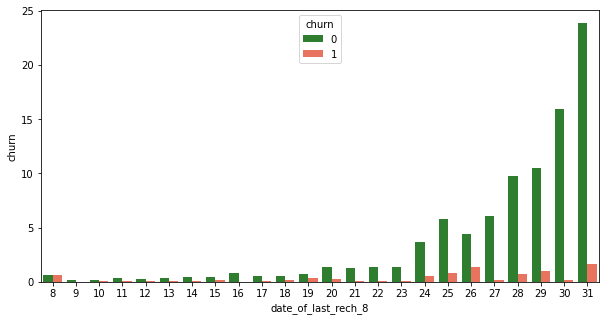

In [170]:

plt.figure(figsize=(10,5))
palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_8", y="churn", hue="churn", data=telecom_df4, palette=palette, 
            estimator=lambda x: len(x) / len(telecom_df4) * 100)

### Driver Variables of Churn and Churn Analysis & Recommendation

- ARPU 7th and 8th - Average Revenue Per User decreases from 6th to 7th month to 8th month as most of the users are churned by 8th month.

- date_of_last_rech_8 - Most of the Users are churned between 25th to 31st of the month. Hence providing offers prior to 25th can reduce the churn. Send out periodic offers to customers between 15th of the month to 25th of the month.

- last_day_rch_amt_8 - Lower the last day recharge amount higher the churn rate. Focus on customers whos last day recharge amount has decrased. Specialy for customers without any recharge amount.

- roam_ic_mou_8 - Higher the incoming roaming amount, higher is the churn rate. Focus on customers whose incoming roaming amount has increased, because they are likely to churn.

- std_ic_t2f_mou_8 - Lower the STD incoming call, higher is the churn rate. Focus on customers whose STD incoming call amount has decreased for that month.

- max_rech_amt_8- Focus on the customer whoes Avg max recharge amount has been decreased